1. На основе учебного ноутбука проведите финальную подготовку данных. Иизмените количество сегментирующих классов с `16` на `5`.

2. Проведите суммарно не менее `10` экспериментов и визуализируйте их результаты (включая точность обучения сетей на одинаковом количестве эпох, например, на `7`):

  - изменив `filters` в сверточных слоях
  - изменив `kernel_size` в сверточных слоях
  - изменив активационную функцию в скрытых слоях с `relu` на `linear` или/и `selu`, `elu`.


**Важно!**

Многие эксперименты могут приводить к переполнению ОЗУ в вашем ноутбуке и сброса кода обучения.

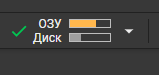



Для предотвращения переполнения ОЗУ может помочь библиотека `gc`. Вставьте строчку `gc.collect()` в цикл ваших экспериментов для сбора и удаления временных данных (кеш).

Перед выполнением задания, пожалуйста, запустите ячейку `Подготовка` ниже:

## Подготовка

### Импорт библиотек

In [ ]:
 # Импортируем модели keras: Model
from tensorflow.keras.models import Model

 # Импортируем стандартные слои keras
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation
from tensorflow.keras.layers import MaxPooling2D, Conv2D, BatchNormalization, UpSampling2D

# Импортируем оптимизатор Adam
from tensorflow.keras.optimizers import Adam

# Импортируем модуль pyplot библиотеки matplotlib для построения графиков
import matplotlib.pyplot as plt

# Импортируем модуль image для работы с изображениями
from tensorflow.keras.preprocessing import image

# Импортируем библиотеку numpy
import numpy as np

# Импортируем методделения выборки
from sklearn.model_selection import train_test_split

# загрузка файлов по HTML ссылке
import gdown

# Для работы с файлами
import os

# Для генерации случайных чисел
import random

import time

# импортируем модель Image для работы с изображениями
from PIL import Image

# очистка ОЗУ
import gc

### Загрузка датасета

грузим и распаковываем архив картинок

In [ ]:
# Загрузка датасета из облака

gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l14/construction_256x192.zip', None, quiet=False)
#gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l14/construction_512x384.zip', None, quiet=False)

!unzip -q 'construction_256x192.zip' # распоковываем архив

Downloading...
From: https://storage.yandexcloud.net/aiueducation/Content/base/l14/construction_256x192.zip
To: /content/construction_256x192.zip
100%|██████████| 214M/214M [00:10<00:00, 20.7MB/s]


In [ ]:
# Глобальные параметры

IMG_WIDTH = 256               # Ширина картинки
IMG_HEIGHT = 192              # Высота картинки
NUM_CLASSES = 16              # Задаем количество классов на изображении
TRAIN_DIRECTORY = 'train'     # Название папки с файлами обучающей выборки
VAL_DIRECTORY = 'val'         # Название папки с файлами проверочной выборки

Загрузим оригинальные изображения (код из лекции):

In [ ]:
train_images = [] # Создаем пустой список для хранений оригинальных изображений обучающей выборки
val_images = [] # Создаем пустой список для хранений оригинальных изображений проверочной выборки

cur_time = time.time()  # Засекаем текущее время

# Проходим по всем файлам в каталоге по указанному пути
for filename in sorted(os.listdir(TRAIN_DIRECTORY+'/original')):
    # Читаем очередную картинку и добавляем ее в список изображений с указанным target_size
    train_images.append(image.load_img(os.path.join(TRAIN_DIRECTORY+'/original',filename),
                                       target_size=(IMG_WIDTH, IMG_HEIGHT)))

# Отображаем время загрузки картинок обучающей выборки
print ('Обучающая выборка загружена. Время загрузки: ', round(time.time() - cur_time, 2), 'c', sep='')

# Отображаем количество элементов в обучающей выборке
print ('Количество изображений: ', len(train_images))

cur_time = time.time() # Засекаем текущее время

# Проходим по всем файлам в каталоге по указанному пути
for filename in sorted(os.listdir(VAL_DIRECTORY+'/original')):
    # Читаем очередную картинку и добавляем ее в список изображений с указанным target_size
    val_images.append(image.load_img(os.path.join(VAL_DIRECTORY+'/original',filename),
                                     target_size=(IMG_WIDTH, IMG_HEIGHT)))

# Отображаем время загрузки картинок проверочной выборки
print ('Проверочная выборка загружена. Время загрузки: ', round(time.time() - cur_time, 2), 'c', sep='')

# Отображаем количество элементов в проверочной выборке
print ('Количество изображений: ', len(val_images))

Обучающая выборка загружена. Время загрузки: 0.64c
Количество изображений:  1900
Проверочная выборка загружена. Время загрузки: 0.03c
Количество изображений:  100


Загрузим сегментированные изображения (код из лекции):

In [ ]:
train_segments = [] # Создаем пустой список для хранений оригинальных изображений обучающей выборки
val_segments = [] # Создаем пустой список для хранений оригинальных изображений проверочной выборки

cur_time = time.time() # Засекаем текущее время

for filename in sorted(os.listdir(TRAIN_DIRECTORY+'/segment')): # Проходим по всем файлам в каталоге по указанному пути
    # Читаем очередную картинку и добавляем ее в список изображений с указанным target_size
    train_segments.append(image.load_img(os.path.join(TRAIN_DIRECTORY+'/segment',filename),
                                       target_size=(IMG_WIDTH, IMG_HEIGHT)))

# Отображаем время загрузки картинок обучающей выборки
print ('Обучающая выборка загружена. Время загрузки: ', round(time.time() - cur_time, 2), 'c', sep='')

# Отображаем количество элементов в обучающем наборе сегментированных изображений
print ('Количество изображений: ', len(train_segments))

cur_time = time.time() # Засекаем текущее время

for filename in sorted(os.listdir(VAL_DIRECTORY+'/segment')): # Проходим по всем файлам в каталоге по указанному пути
    # Читаем очередную картинку и добавляем ее в список изображений с указанным target_size
    val_segments.append(image.load_img(os.path.join(VAL_DIRECTORY+'/segment',filename),
                                     target_size=(IMG_WIDTH, IMG_HEIGHT)))

# Отображаем время загрузки картинок проверочной выборки
print ('Проверочная выборка загружена. Время загрузки: ', round(time.time() - cur_time, 2), 'c', sep='')

# Отображаем количество элементов в проверочном наборе сегментированных изображений
print ('Количество изображений: ', len(val_segments))

Обучающая выборка загружена. Время загрузки: 0.62c
Количество изображений:  1900
Проверочная выборка загружена. Время загрузки: 0.03c
Количество изображений:  100


## Решение


In [ ]:
# Функция для обработки сегментов
def process_segment(segments):
    processed = []
    for seg in segments:
        seg_array = np.array(seg)
        if seg_array.ndim == 3:
            seg_array = seg_array[:, :, 0]  # Берем первый канал если изображение RGB
        seg_array = seg_array % NUM_CLASSES  # Преобразуем метки в диапазон 0-4
        processed.append(seg_array)
    return processed

# Обработка сегментов
train_segments = process_segment(train_segments)
val_segments = process_segment(val_segments)

In [ ]:
# Преобразование изображений и меток в numpy массивы
X_train = np.array([image.img_to_array(img)/255.0 for img in train_images])
y_train = np.array([seg for seg in train_segments], dtype=np.uint8)

X_val = np.array([image.img_to_array(img)/255.0 for img in val_images])
y_val = np.array([seg for seg in val_segments], dtype=np.uint8)

In [ ]:
# Модифицированная функция U-Net с полной параметризацией
def masked_unet(class_count, input_shape, filters_list, kernel_size=(3,3), activation='relu'):
    img_input = Input(input_shape)
    # (Чтобы опять всё не легло!) Добавлена проверка kernel_size
    if isinstance(kernel_size, list):
        assert len(kernel_size) == 5, "kernel_size list must have 5 elements"
    else:
        kernel_size = [kernel_size]*5
    # Block 1
    x = Conv2D(filters_list[0], kernel_size[0], padding='same', name='block1_conv1')(img_input)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    x = Conv2D(filters_list[0], kernel_size[0], padding='same', name='block1_conv2')(x)
    x = BatchNormalization()(x)
    block_1_out = Activation(activation)(x)
    block_1_out_mask = Conv2D(filters_list[0], (1,1), padding='same')(block_1_out)
    x = MaxPooling2D()(block_1_out)

    # Block 2
    x = Conv2D(filters_list[1], kernel_size[1], padding='same', name='block2_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    x = Conv2D(filters_list[1], kernel_size[1], padding='same', name='block2_conv2')(x)
    x = BatchNormalization()(x)
    block_2_out = Activation(activation)(x)
    block_2_out_mask = Conv2D(filters_list[1], (1,1), padding='same')(block_2_out)
    x = MaxPooling2D()(block_2_out)

    # Block 3
    x = Conv2D(filters_list[2], kernel_size[2], padding='same', name='block3_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    x = Conv2D(filters_list[2], kernel_size[2], padding='same', name='block3_conv2')(x)
    x = BatchNormalization()(x)
    block_3_out = Activation(activation)(x)
    block_3_out_mask = Conv2D(filters_list[2], (1,1), padding='same')(block_3_out)
    x = MaxPooling2D()(block_3_out)

    # Block 4
    x = Conv2D(filters_list[3], kernel_size[3], padding='same', name='block4_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    x = Conv2D(filters_list[3], kernel_size[3], padding='same', name='block4_conv2')(x)
    x = BatchNormalization()(x)
    block_4_out = Activation(activation)(x)
    block_4_out_mask = Conv2D(filters_list[3], (1,1), padding='same')(block_4_out)
    x = MaxPooling2D()(block_4_out)

    # Block 5
    x = Conv2D(filters_list[4], kernel_size[4], padding='same', name='block5_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    x = Conv2D(filters_list[4], kernel_size[4], padding='same', name='block5_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)

    # Декодинг
    # UP 1
    x = Conv2DTranspose(filters_list[3], (2,2), strides=(2,2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    x = concatenate([x, block_4_out, block_4_out_mask])
    x = Conv2D(filters_list[3], kernel_size[3], padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)

    # UP 2
    x = Conv2DTranspose(filters_list[2], (2,2), strides=(2,2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    x = concatenate([x, block_3_out, block_3_out_mask])
    x = Conv2D(filters_list[2], kernel_size[2], padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)

    # UP 3
    x = Conv2DTranspose(filters_list[1], (2,2), strides=(2,2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    x = concatenate([x, block_2_out, block_2_out_mask])
    x = Conv2D(filters_list[1], kernel_size[1], padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)

    # UP 4
    x = Conv2DTranspose(filters_list[0], (2,2), strides=(2,2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    x = concatenate([x, block_1_out, block_1_out_mask])
    x = Conv2D(filters_list[0], kernel_size[0], padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)

    # Последний слой
    x = Conv2D(class_count, (3,3), activation='softmax', padding='same')(x)

    model = Model(img_input, x)
    model.compile(optimizer=Adam(learning_rate=1e-3),
                 loss='sparse_categorical_crossentropy',
                 metrics=['sparse_categorical_accuracy'])
    return model

In [ ]:
experiments = [
    # Базовый вариант (оригинальные параметры)
    {'name': 'Basic',
     'filters': [64, 128, 256, 512, 512],
     'kernel_size': (3,3),
     'activation': 'relu'},

    # Фильтры в 2 раза больше
    {'name': 'Filters*2',
     'filters': [128, 256, 512, 1024, 1024],
     'kernel_size': (3,3),
     'activation': 'relu'},

    # Фильтры в 2 раза меньше. При сохранении весов из-за / была ошибка
    {'name': 'Filters_del_2',
     'filters': [32, 64, 128, 256, 256],
     'kernel_size': (3,3),
     'activation': 'relu'},

    # Увеличен kernel
    {'name': 'Kernel 5, 5',
     'filters': [64, 128, 256, 512, 512],
     'kernel_size': (5,5),
     'activation': 'relu'},

    # Уменьшен kernel
    {'name': 'Kernel 1,1',
     'filters': [64, 128, 256, 512, 512],
     'kernel_size': (1,1),
     'activation': 'relu'},

    # Линейная активация
    {'name': 'Linear',
     'filters': [64, 128, 256, 512, 512],
     'kernel_size': (3,3),
     'activation': 'linear'},

    # SELU активация
    {'name': 'SELU',
     'filters': [64, 128, 256, 512, 512],
     'kernel_size': (3,3),
     'activation': 'selu'},

    # ELU активация
    {'name': 'ELU',
     'filters': [64, 128, 256, 512, 512],
     'kernel_size': (3,3),
     'activation': 'elu'},

    # Kernel 5x5 и ELU
    {'name': 'Kernel 5,5 и ELU',
     'filters': [64, 128, 256, 512, 512],
     'kernel_size': (5,5),
     'activation': 'elu'},

    # Удвоенные фильтры и SELU
    {'name': 'Filters*2 и SELU',
     'filters': [128, 256, 512, 1024, 1024],
     'kernel_size': (3,3),
     'activation': 'selu'},

    # Куча разных kernel_size
    {'name': 'Kernel_sizes',
     'filters': [64, 128, 256, 512, 512],
     'kernel_size': [(5,5), (3,3), (3,3), (1,1), (1,1)],
     'activation': 'relu'}
]


Starting experiment: Basic
Parameters: filters=[64, 128, 256, 512, 512], kernel=(3, 3), activation=relu
Epoch 1/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 202s 581ms/step - loss: 0.9842 - sparse_categorical_accuracy: 0.6368 - val_loss: 2.9718 - val_sparse_categorical_accuracy: 0.2635
Epoch 2/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 106s 395ms/step - loss: 0.6194 - sparse_categorical_accuracy: 0.7553 - val_loss: 0.7924 - val_sparse_categorical_accuracy: 0.6944
Epoch 3/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 93s 393ms/step - loss: 0.5541 - sparse_categorical_accuracy: 0.7831 - val_loss: 0.9114 - val_sparse_categorical_accuracy: 0.7267
Epoch 4/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 143s 395ms/step - loss: 0.5051 - sparse_categorical_accuracy: 0.8050 - val_loss: 0.7531 - val_sparse_categorical_accuracy: 0.7255
Epoch 5/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 94s 393ms/step - loss: 0.4823 - sparse_categorical_accuracy: 0.8146 - val_loss: 0.7692 - val_sparse_categorical_accuracy: 0.7067
Epoch 6/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 94s 397ms/ste

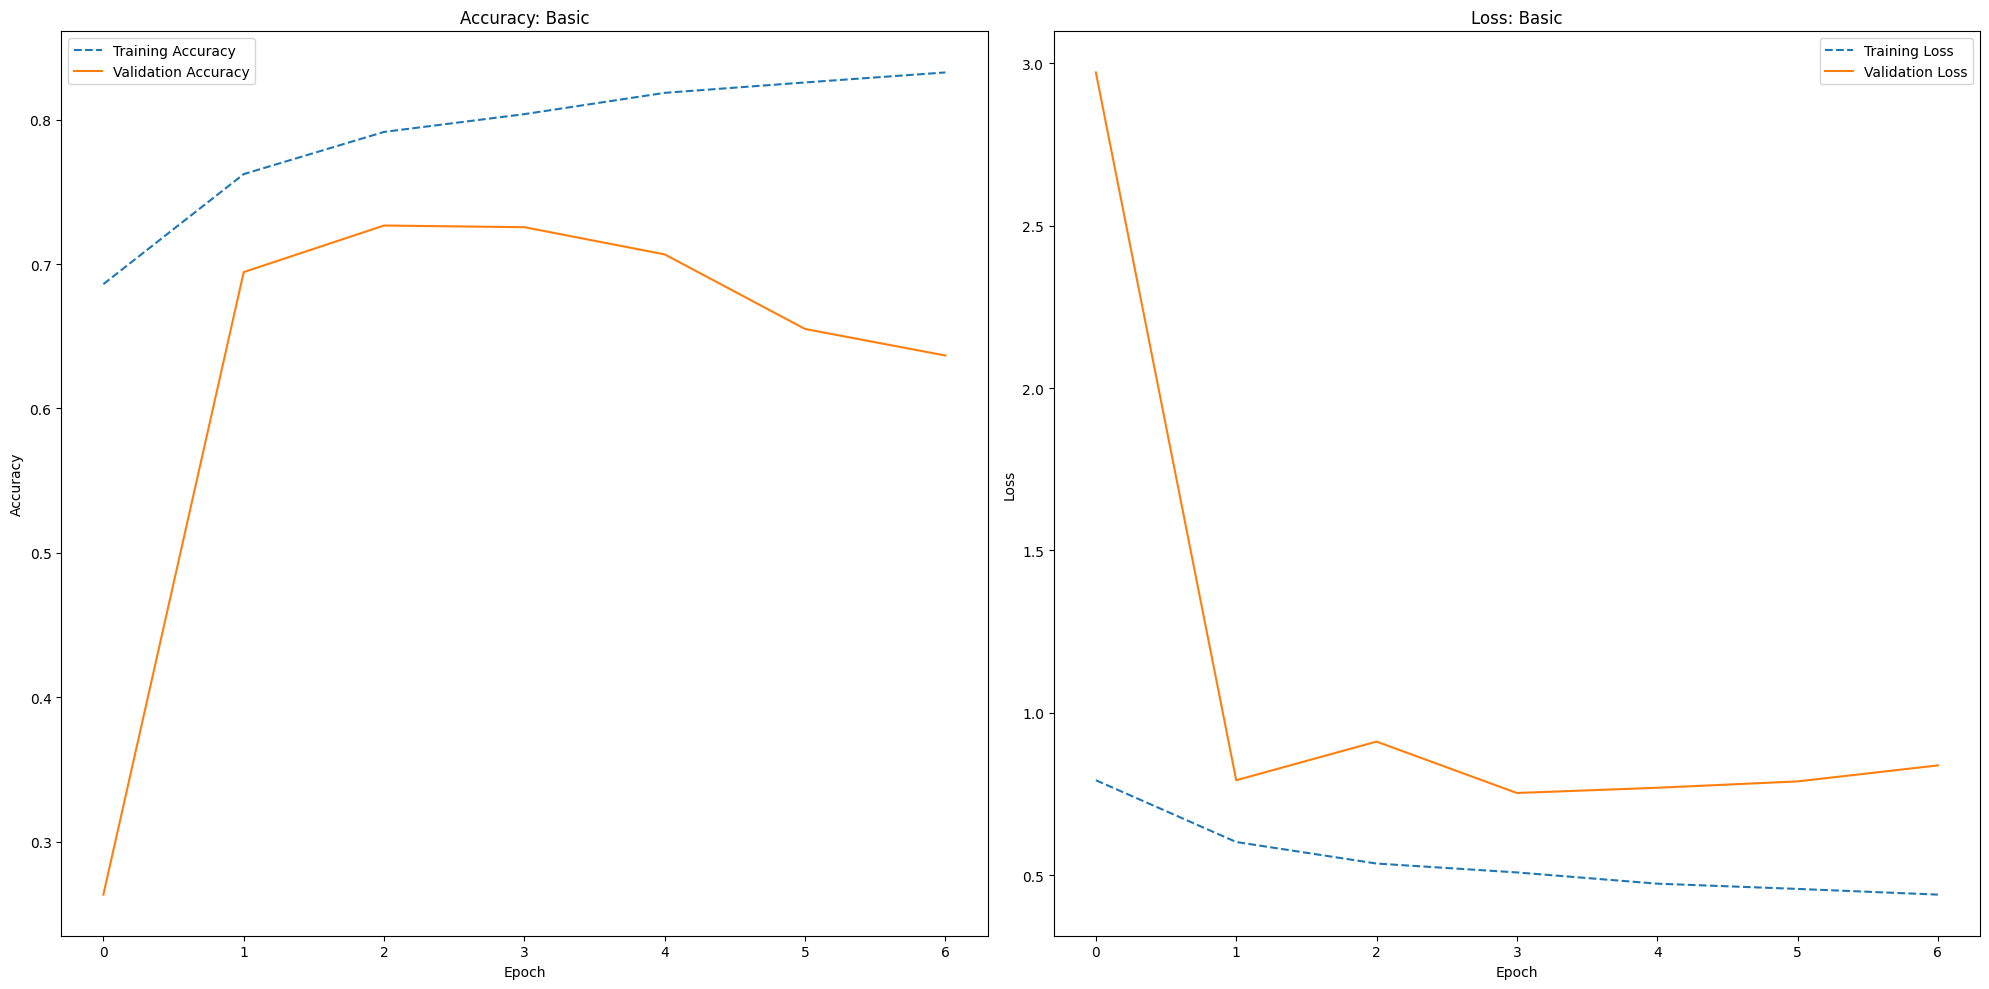

Experiment Basic completed.


Starting experiment: Filters*2
Parameters: filters=[128, 256, 512, 1024, 1024], kernel=(3, 3), activation=relu
Epoch 1/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 487s 2s/step - loss: 0.9564 - sparse_categorical_accuracy: 0.6383 - val_loss: 1.8313 - val_sparse_categorical_accuracy: 0.3989
Epoch 2/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 328s 1s/step - loss: 0.6337 - sparse_categorical_accuracy: 0.7490 - val_loss: 0.8401 - val_sparse_categorical_accuracy: 0.7182
Epoch 3/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 322s 1s/step - loss: 0.5761 - sparse_categorical_accuracy: 0.7702 - val_loss: 1.1770 - val_sparse_categorical_accuracy: 0.5624
Epoch 4/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 300s 1s/step - loss: 0.5224 - sparse_categorical_accuracy: 0.7995 - val_loss: 0.8687 - val_sparse_categorical_accuracy: 0.6918
Epoch 5/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 323s 1s/step - loss: 0.4888 - sparse_categorical_accuracy: 0.8120 - val_loss: 0.7366 - val_sparse_categorical_accuracy: 0.7120
Epoch 6/7
238/238 ━━━━━━━━━━━

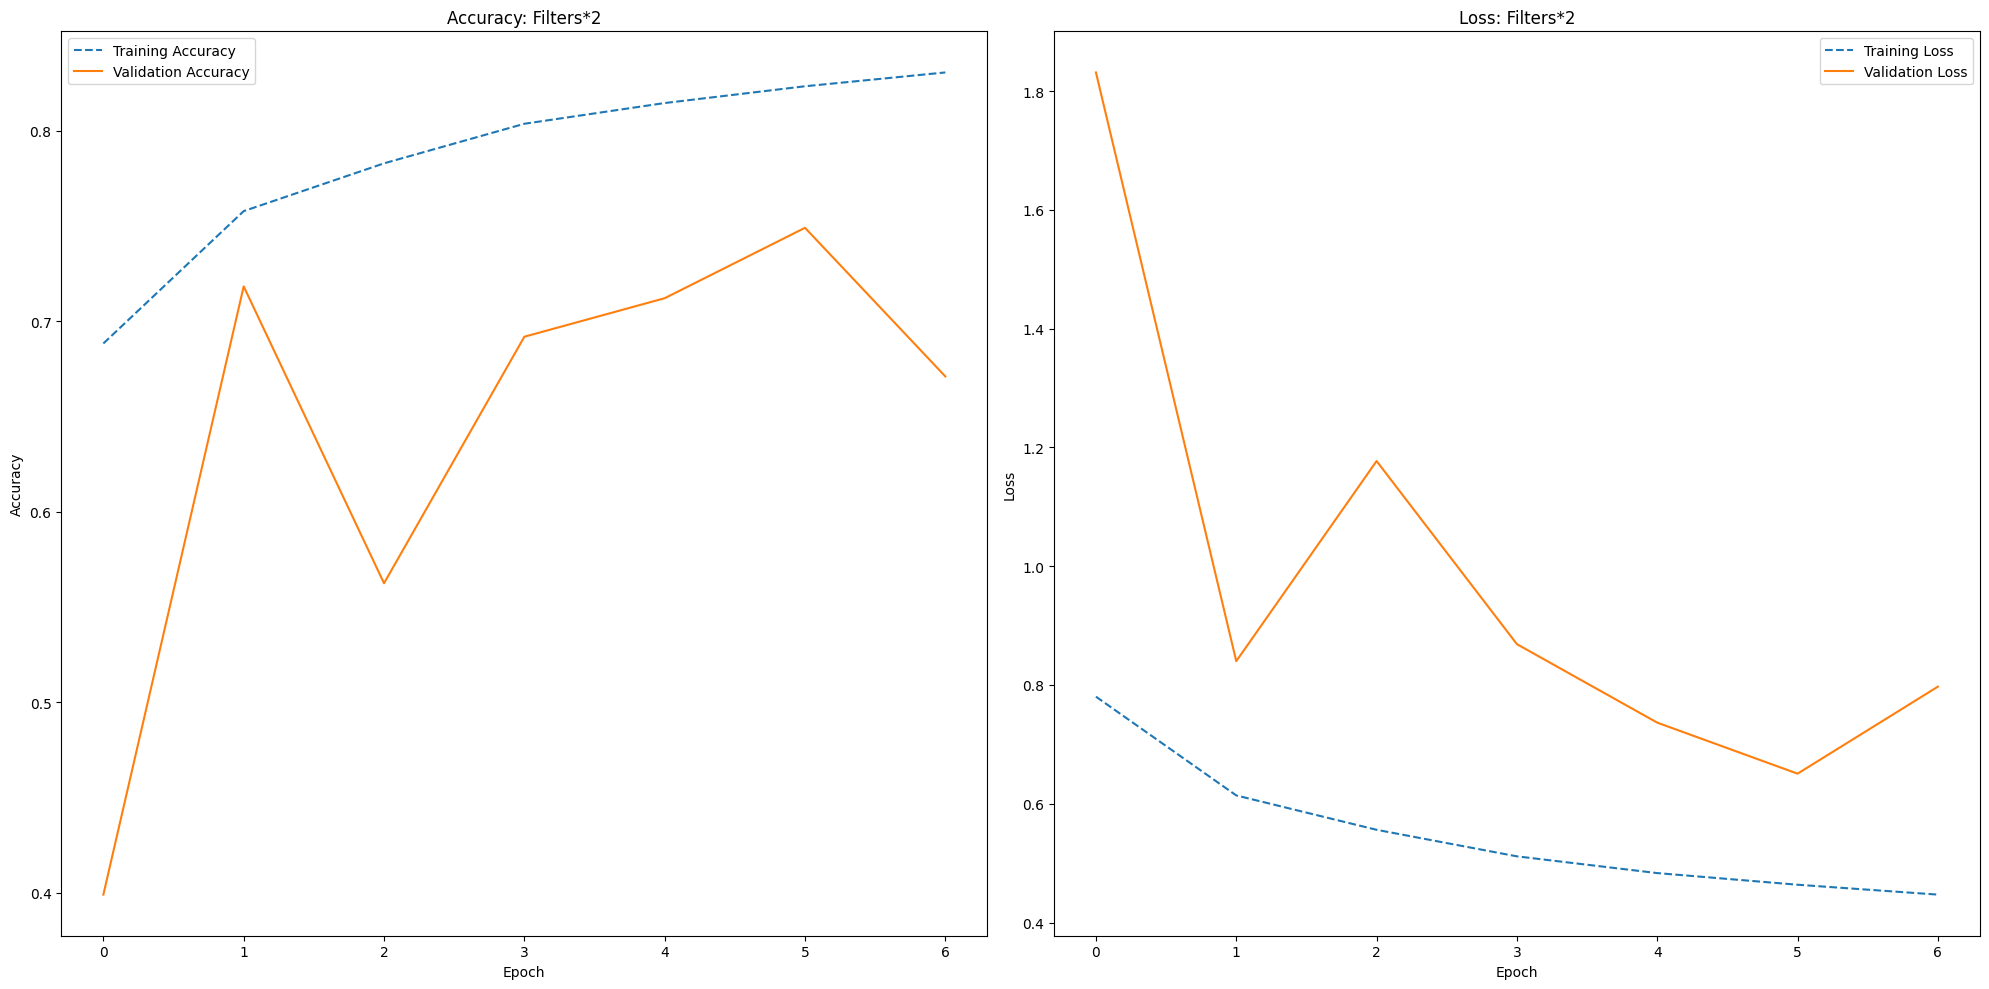

Experiment Filters*2 completed.


Starting experiment: Filters_del_2
Parameters: filters=[32, 64, 128, 256, 256], kernel=(3, 3), activation=relu
Epoch 1/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 95s 248ms/step - loss: 0.9733 - sparse_categorical_accuracy: 0.6679 - val_loss: 1.3293 - val_sparse_categorical_accuracy: 0.4922
Epoch 2/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 92s 140ms/step - loss: 0.5728 - sparse_categorical_accuracy: 0.7759 - val_loss: 0.7526 - val_sparse_categorical_accuracy: 0.7218
Epoch 3/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 40s 138ms/step - loss: 0.5312 - sparse_categorical_accuracy: 0.7938 - val_loss: 0.6899 - val_sparse_categorical_accuracy: 0.7204
Epoch 4/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 33s 139ms/step - loss: 0.4794 - sparse_categorical_accuracy: 0.8156 - val_loss: 0.7741 - val_sparse_categorical_accuracy: 0.6751
Epoch 5/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 33s 139ms/step - loss: 0.4614 - sparse_categorical_accuracy: 0.8262 - val_loss: 0.6903 - val_sparse_categorical_accuracy: 0.7286
Epoch 6/7
238/2

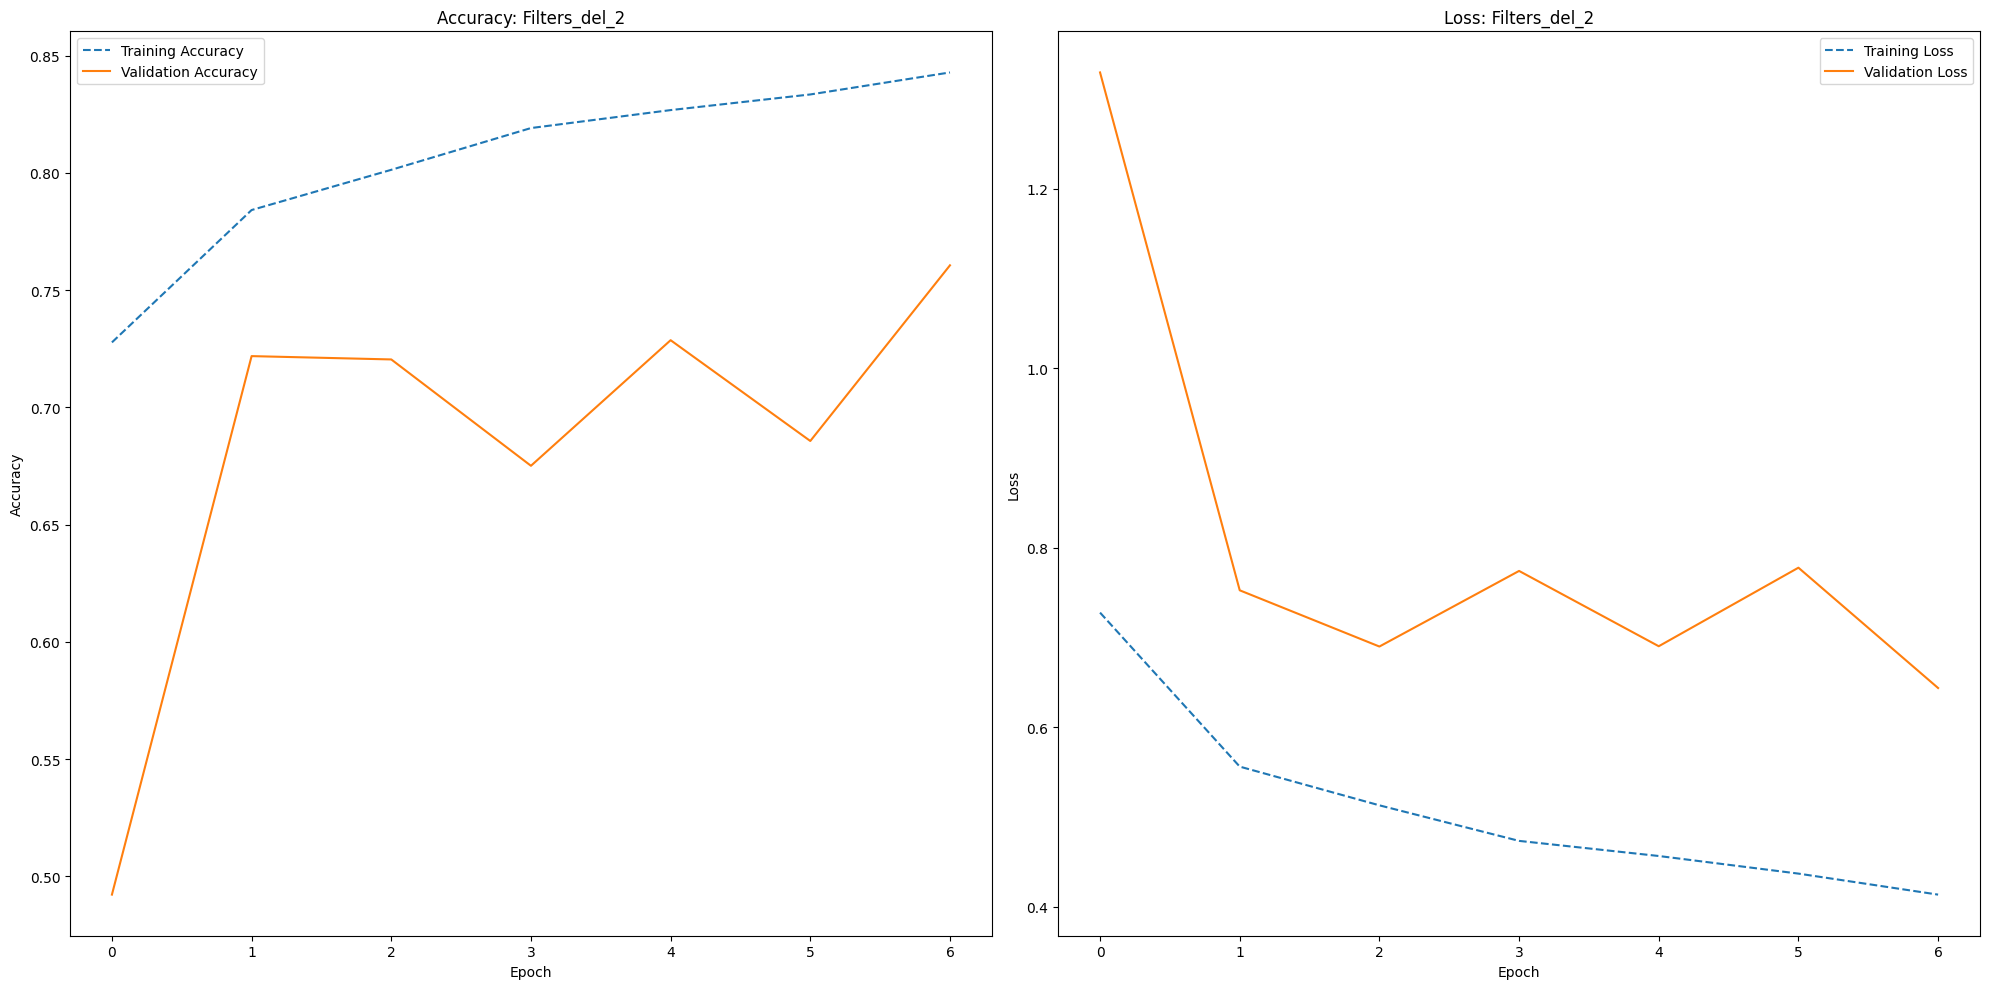

Experiment Filters_del_2 completed.


Starting experiment: Kernel 5, 5
Parameters: filters=[64, 128, 256, 512, 512], kernel=(5, 5), activation=relu
Epoch 1/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 307s 962ms/step - loss: 0.9998 - sparse_categorical_accuracy: 0.6511 - val_loss: 1.0266 - val_sparse_categorical_accuracy: 0.6428
Epoch 2/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 180s 754ms/step - loss: 0.6173 - sparse_categorical_accuracy: 0.7581 - val_loss: 0.8192 - val_sparse_categorical_accuracy: 0.6626
Epoch 3/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 204s 761ms/step - loss: 0.5694 - sparse_categorical_accuracy: 0.7798 - val_loss: 0.8149 - val_sparse_categorical_accuracy: 0.7245
Epoch 4/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 179s 753ms/step - loss: 0.5293 - sparse_categorical_accuracy: 0.7969 - val_loss: 0.7214 - val_sparse_categorical_accuracy: 0.7249
Epoch 5/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 180s 758ms/step - loss: 0.4974 - sparse_categorical_accuracy: 0.8117 - val_loss: 0.7650 - val_sparse_categorical_accuracy: 0.7379
Epoch 6

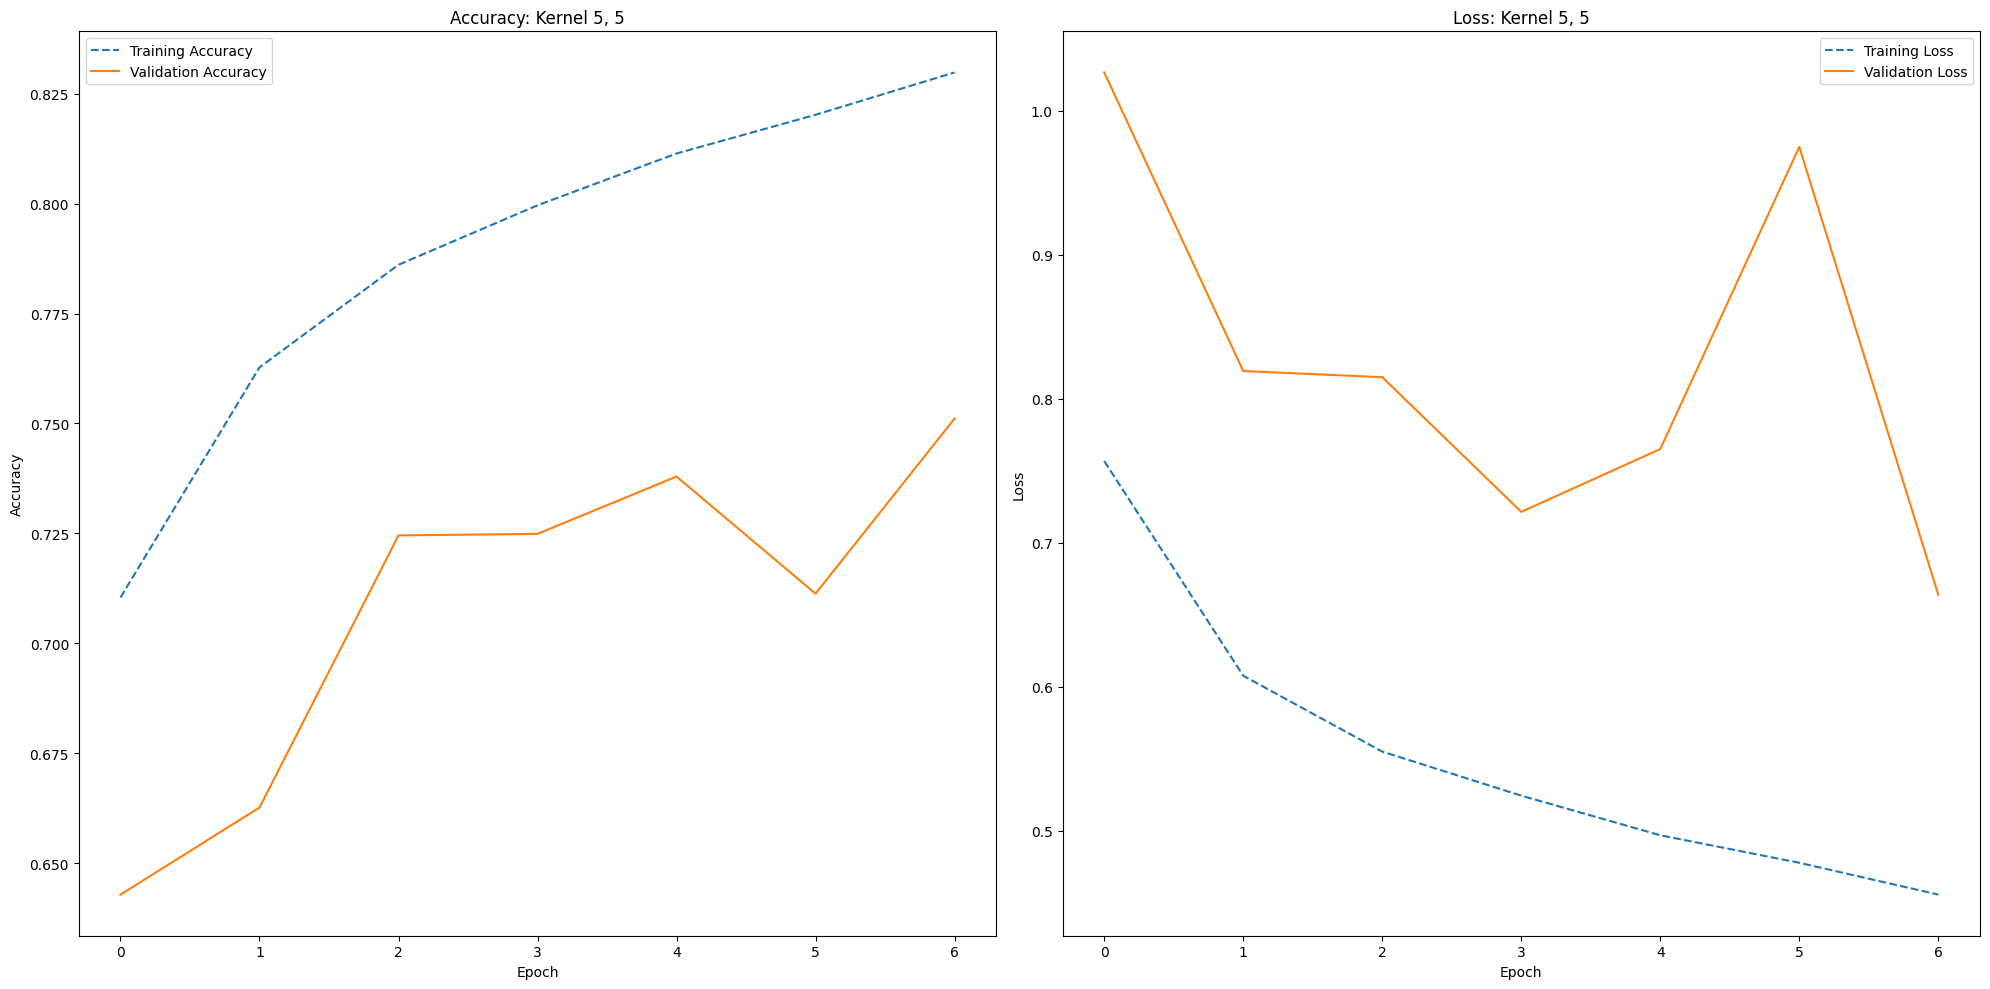

Experiment Kernel 5, 5 completed.


Starting experiment: Kernel 1,1
Parameters: filters=[64, 128, 256, 512, 512], kernel=(1, 1), activation=relu
Epoch 1/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 84s 241ms/step - loss: 1.0532 - sparse_categorical_accuracy: 0.6066 - val_loss: 1.4828 - val_sparse_categorical_accuracy: 0.6417
Epoch 2/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 41s 171ms/step - loss: 0.7223 - sparse_categorical_accuracy: 0.6887 - val_loss: 0.9221 - val_sparse_categorical_accuracy: 0.6041
Epoch 3/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 41s 171ms/step - loss: 0.6844 - sparse_categorical_accuracy: 0.7113 - val_loss: 0.9211 - val_sparse_categorical_accuracy: 0.5727
Epoch 4/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 41s 170ms/step - loss: 0.6888 - sparse_categorical_accuracy: 0.7067 - val_loss: 0.8670 - val_sparse_categorical_accuracy: 0.5732
Epoch 5/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 41s 171ms/step - loss: 0.6650 - sparse_categorical_accuracy: 0.7196 - val_loss: 0.9797 - val_sparse_categorical_accuracy: 0.5585
Epoch 6/7
238/2

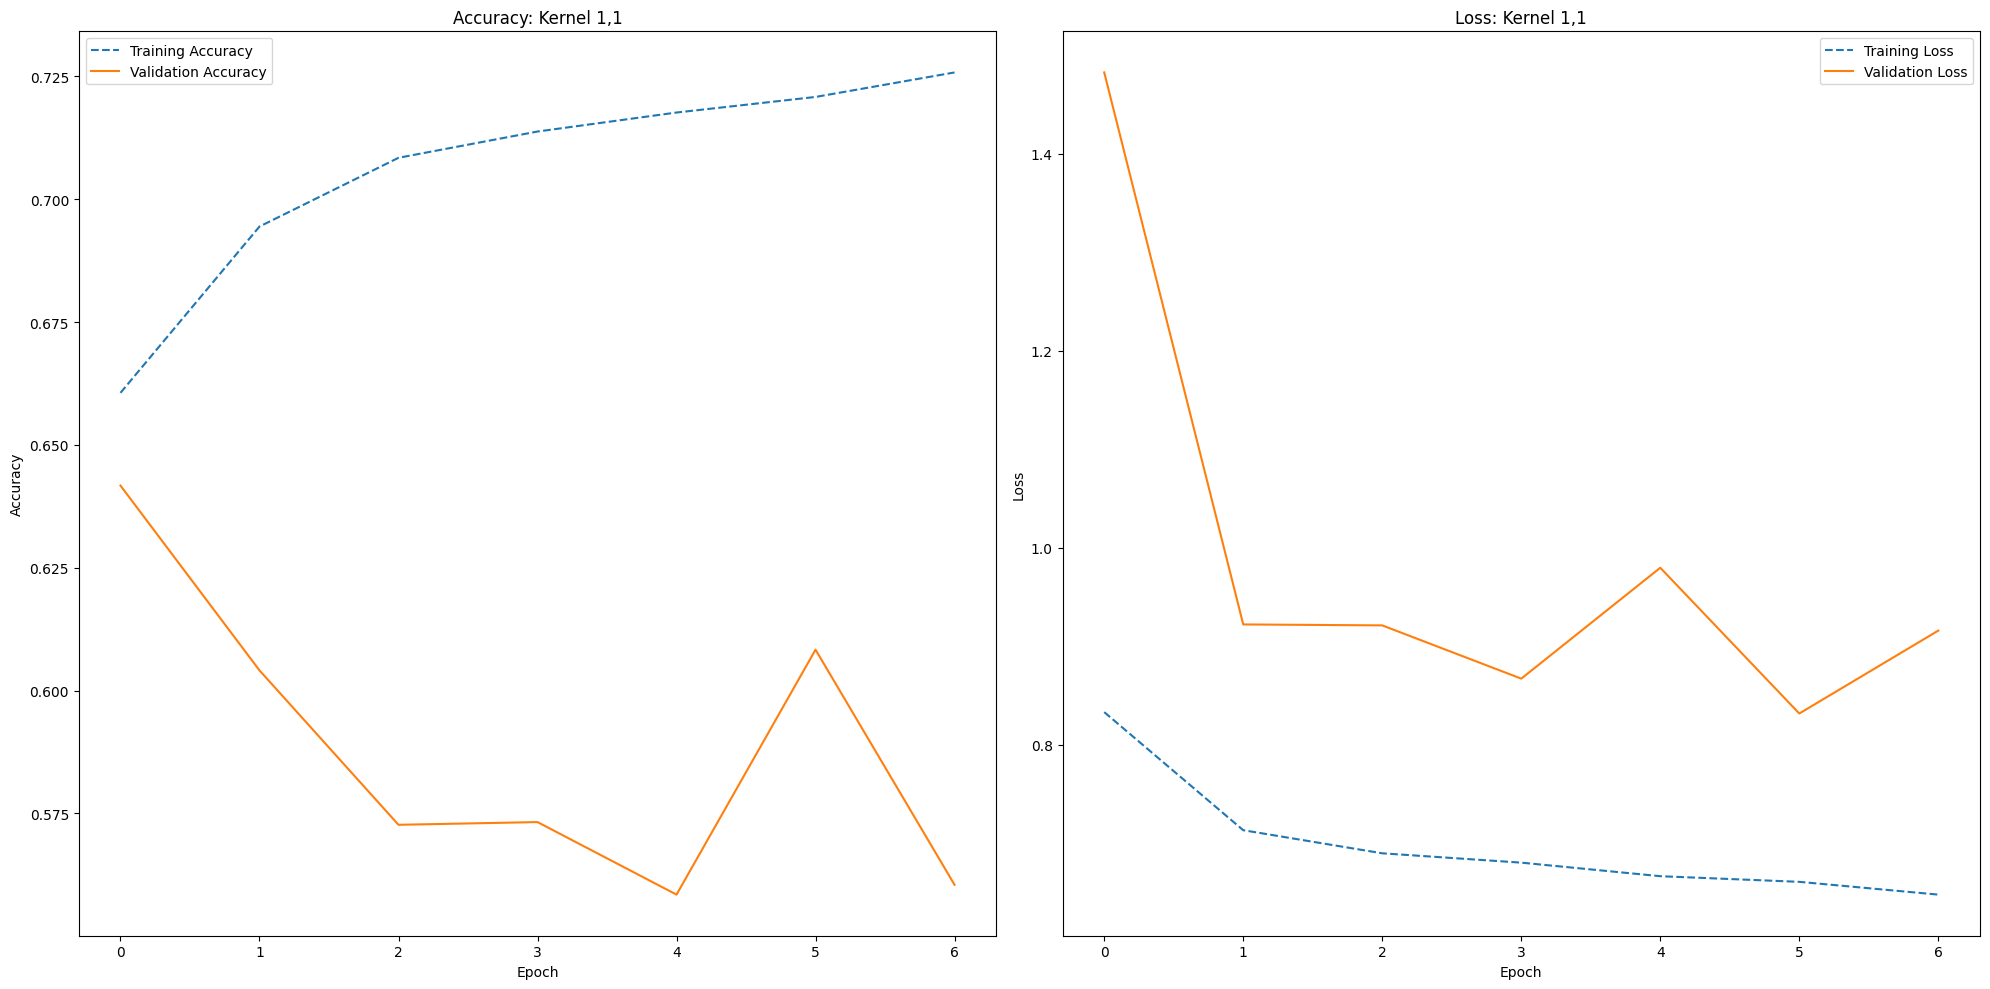

Experiment Kernel 1,1 completed.


Starting experiment: Linear
Parameters: filters=[64, 128, 256, 512, 512], kernel=(3, 3), activation=linear
Epoch 1/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 131s 453ms/step - loss: 1.9255 - sparse_categorical_accuracy: 0.5166 - val_loss: 1.3488 - val_sparse_categorical_accuracy: 0.7081
Epoch 2/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 118s 398ms/step - loss: 0.6970 - sparse_categorical_accuracy: 0.7276 - val_loss: 0.8789 - val_sparse_categorical_accuracy: 0.7201
Epoch 3/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 142s 398ms/step - loss: 0.6568 - sparse_categorical_accuracy: 0.7433 - val_loss: 0.8451 - val_sparse_categorical_accuracy: 0.6877
Epoch 4/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 142s 398ms/step - loss: 0.6197 - sparse_categorical_accuracy: 0.7572 - val_loss: 1.0795 - val_sparse_categorical_accuracy: 0.7050
Epoch 5/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 142s 398ms/step - loss: 0.5920 - sparse_categorical_accuracy: 0.7721 - val_loss: 0.7979 - val_sparse_categorical_accuracy: 0.7353
Epoch 6/7
238

In [ ]:
# Цикл обучения
histories = []
for exp in experiments:
    print(f"\nStarting experiment: {exp['name']}")
    print(f"Parameters: filters={exp['filters']}, kernel={exp['kernel_size']}, activation={exp['activation']}")

    # Создание модели
    model = masked_unet(
        class_count=NUM_CLASSES,
        input_shape=(IMG_WIDTH, IMG_HEIGHT, 3),
        filters_list=exp['filters'],
        kernel_size=exp['kernel_size'],
        activation=exp['activation']
    )

    # Обучение
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=7,
        batch_size=8,
        verbose=1
    )

    # Сохранение истории обучения
    histories.append({
        'name': exp['name'],
        'history': history.history,
        'params': exp
    })
    # Сохранение весов модели
    safe_name = exp['name'].replace(' ', '_').lower()
    weights_filename = f"{safe_name}.weights.h5"
    model.save_weights(weights_filename)
    print(f"Веса в {weights_filename}")
    # Визуализация для текущей модели
    plt.figure(figsize=(20, 10))

    # График точности
    plt.subplot(1, 2, 1)
    plt.plot(history.history['sparse_categorical_accuracy'], '--', label='Training Accuracy')
    plt.plot(history.history['val_sparse_categorical_accuracy'], '-', label='Validation Accuracy')
    plt.title(f'Accuracy: {exp["name"]}')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    # График потерь
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], '--', label='Training Loss')
    plt.plot(history.history['val_loss'], '-', label='Validation Loss')
    plt.title(f'Loss: {exp["name"]}')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Очистка памяти
    del model
    gc.collect()
    print(f"Experiment {exp['name']} completed.\n")


Skipping experiment: Basic

Skipping experiment: Filters*2

Skipping experiment: Filters_del_2

Skipping experiment: Kernel 5, 5

Starting experiment: Kernel 1,1
Parameters: filters=[64, 128, 256, 512, 512], kernel=(1, 1), activation=relu
Epoch 1/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 97s 258ms/step - loss: 0.9768 - sparse_categorical_accuracy: 0.6319 - val_loss: 1.0804 - val_sparse_categorical_accuracy: 0.6414
Epoch 2/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 97s 166ms/step - loss: 0.7183 - sparse_categorical_accuracy: 0.6987 - val_loss: 0.9070 - val_sparse_categorical_accuracy: 0.5942
Epoch 3/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 43s 174ms/step - loss: 0.6921 - sparse_categorical_accuracy: 0.7073 - val_loss: 0.8754 - val_sparse_categorical_accuracy: 0.6087
Epoch 4/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 80s 167ms/step - loss: 0.6814 - sparse_categorical_accuracy: 0.7150 - val_loss: 0.9201 - val_sparse_categorical_accuracy: 0.5862
Epoch 5/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 43s 174ms/step - loss: 0.6725 - sparse_categorica

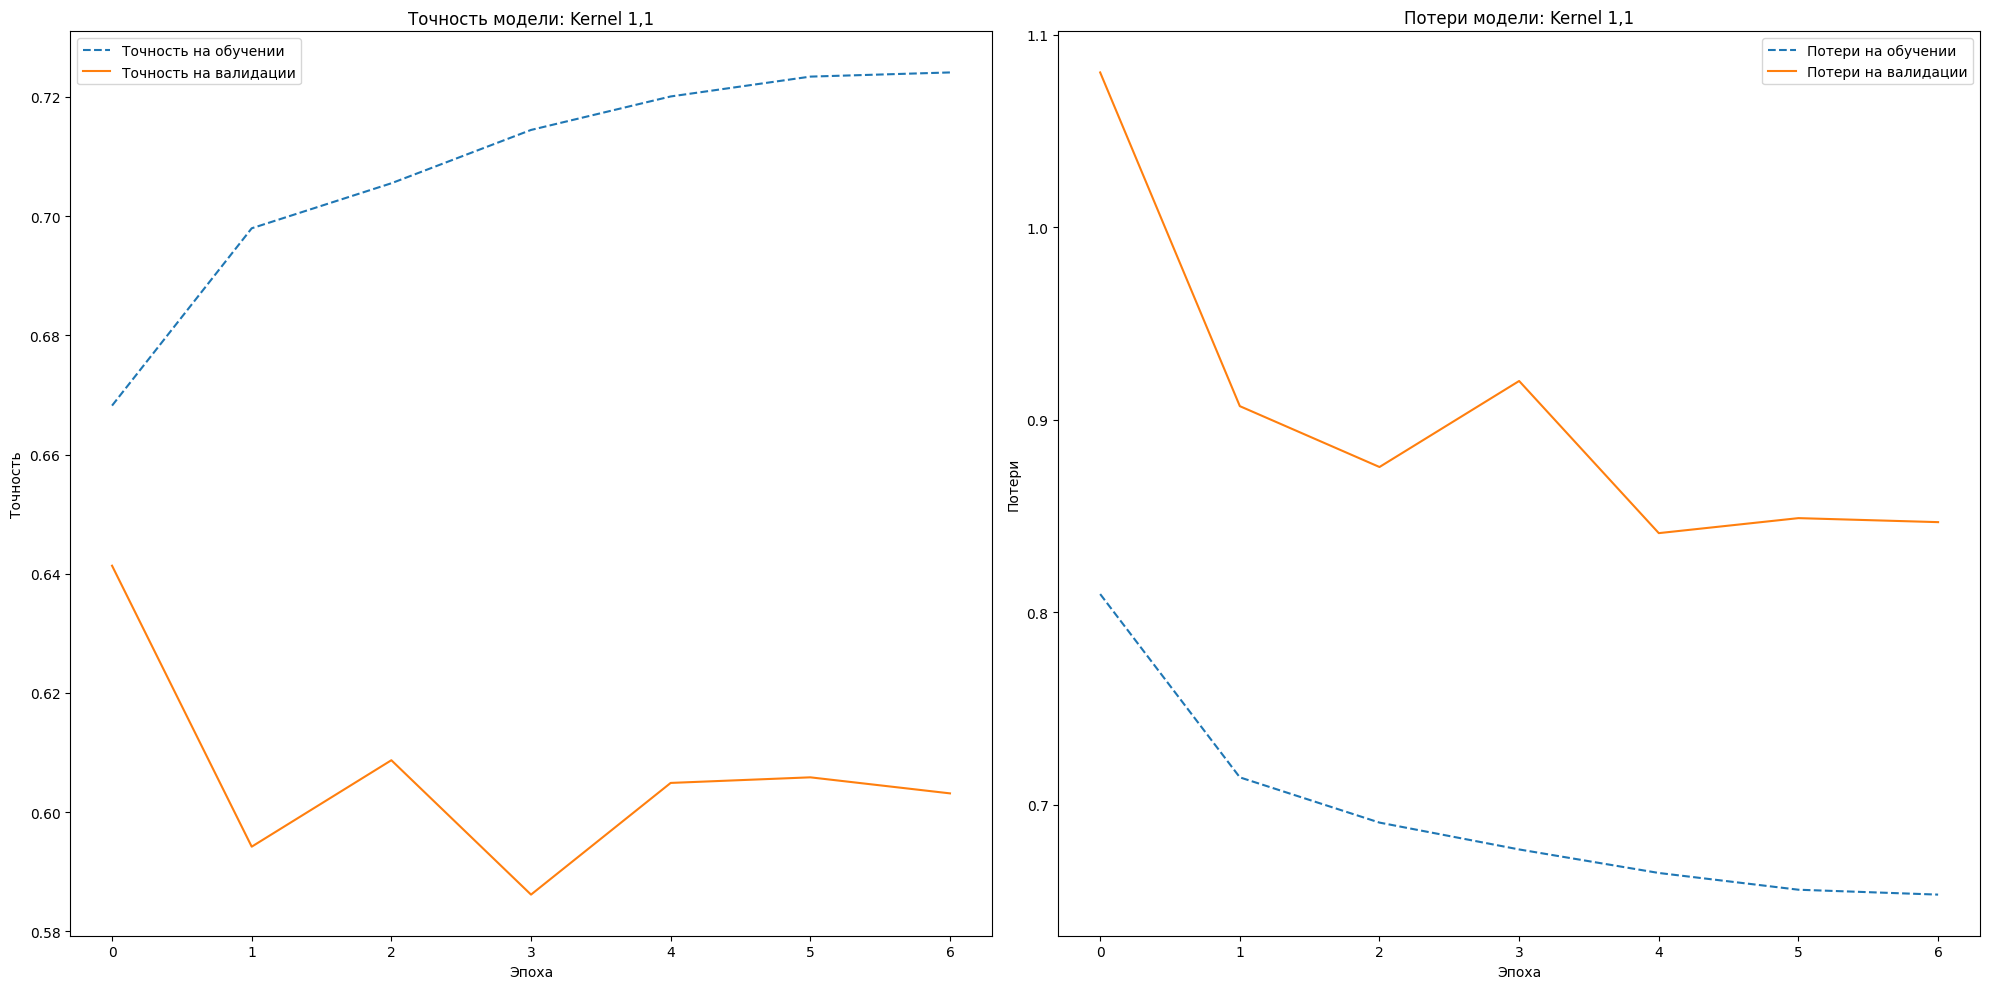

Эксперимент Kernel 1,1 завершен.


Starting experiment: Linear
Parameters: filters=[64, 128, 256, 512, 512], kernel=(3, 3), activation=linear
Epoch 1/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 188s 555ms/step - loss: 1.9755 - sparse_categorical_accuracy: 0.4846 - val_loss: 0.9475 - val_sparse_categorical_accuracy: 0.7132
Epoch 2/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 121s 403ms/step - loss: 0.6808 - sparse_categorical_accuracy: 0.7357 - val_loss: 1.0254 - val_sparse_categorical_accuracy: 0.6928
Epoch 3/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 143s 409ms/step - loss: 0.6334 - sparse_categorical_accuracy: 0.7540 - val_loss: 1.1302 - val_sparse_categorical_accuracy: 0.6074
Epoch 4/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 141s 406ms/step - loss: 0.6254 - sparse_categorical_accuracy: 0.7564 - val_loss: 0.8653 - val_sparse_categorical_accuracy: 0.7143
Epoch 5/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 97s 407ms/step - loss: 0.6288 - sparse_categorical_accuracy: 0.7578 - val_loss: 0.9339 - val_sparse_categorical_accuracy: 0.6688
Epoch 6/7
238/

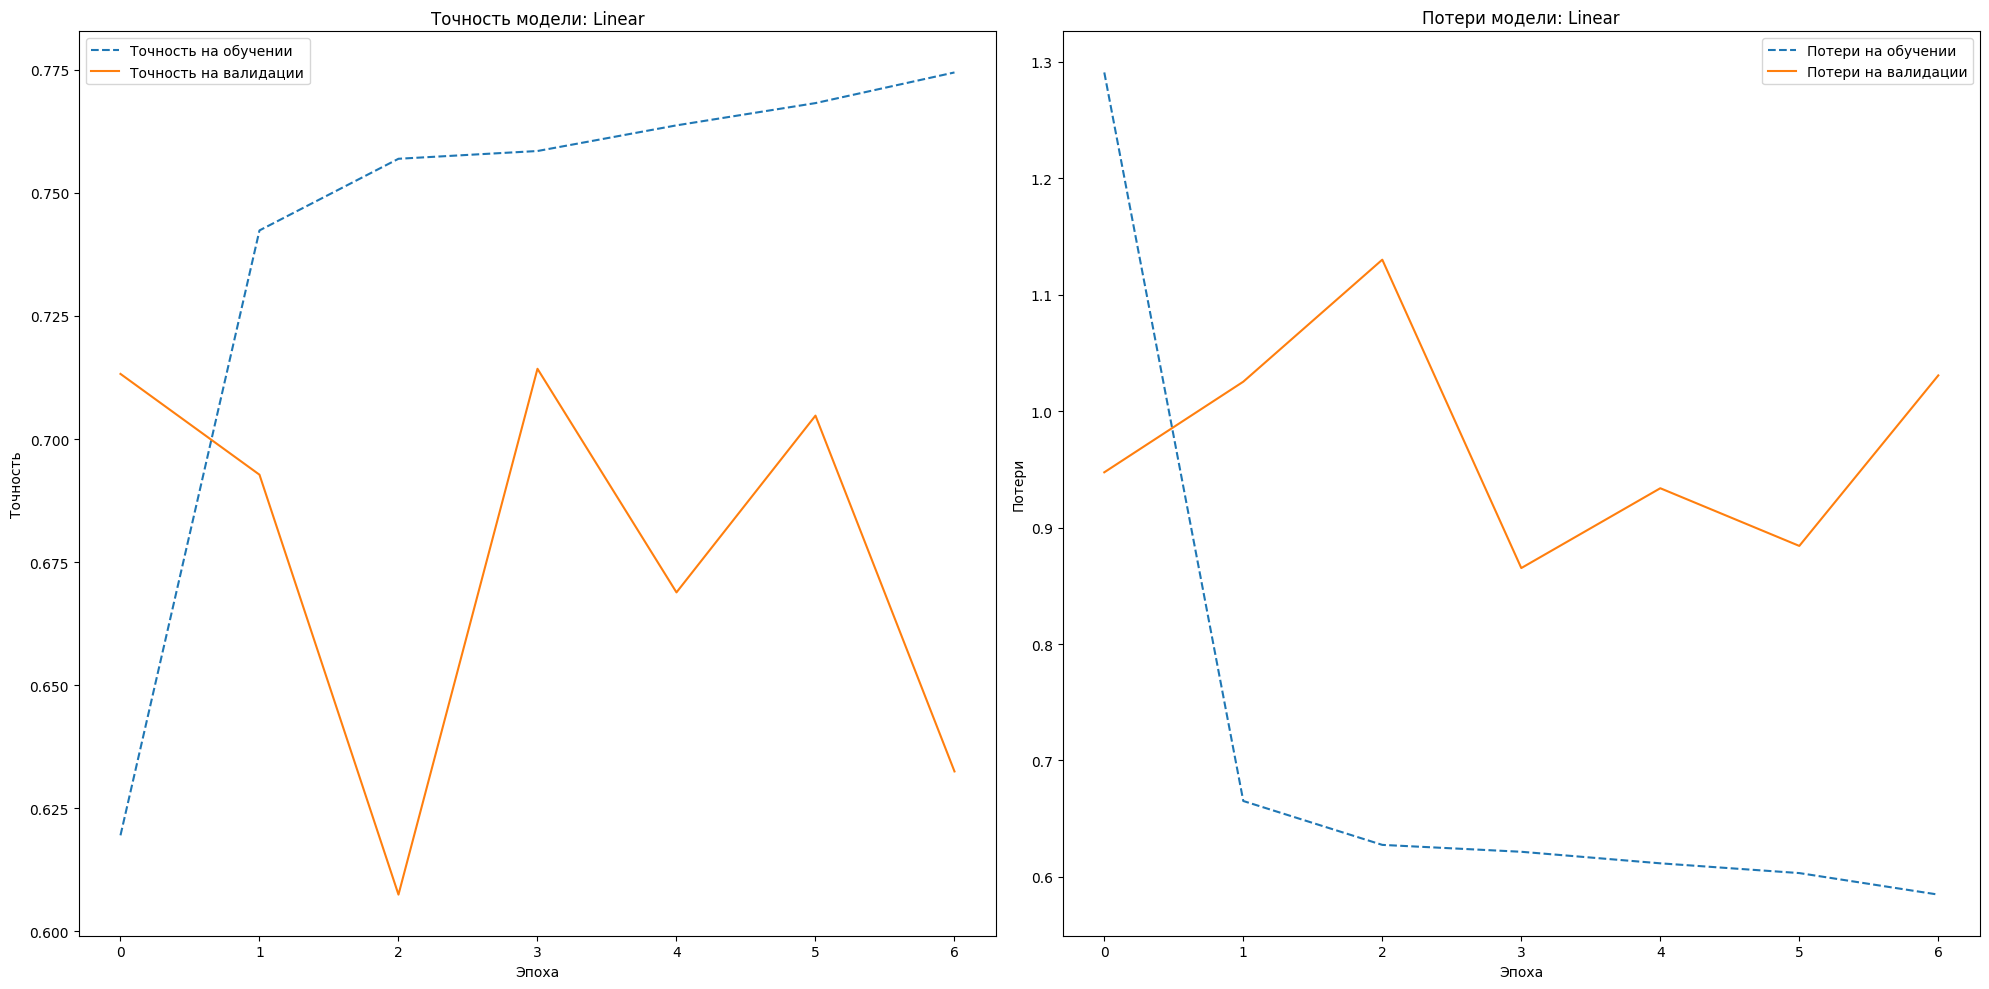

Эксперимент Linear завершен.


Starting experiment: SELU
Parameters: filters=[64, 128, 256, 512, 512], kernel=(3, 3), activation=selu
Epoch 1/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 134s 467ms/step - loss: 1.8770 - sparse_categorical_accuracy: 0.5203 - val_loss: 1.1586 - val_sparse_categorical_accuracy: 0.7099
Epoch 2/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 118s 414ms/step - loss: 0.6944 - sparse_categorical_accuracy: 0.7226 - val_loss: 0.7847 - val_sparse_categorical_accuracy: 0.7229
Epoch 3/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 143s 419ms/step - loss: 0.6202 - sparse_categorical_accuracy: 0.7562 - val_loss: 0.7871 - val_sparse_categorical_accuracy: 0.7177
Epoch 4/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 98s 413ms/step - loss: 0.5844 - sparse_categorical_accuracy: 0.7739 - val_loss: 1.0325 - val_sparse_categorical_accuracy: 0.6088
Epoch 5/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 143s 418ms/step - loss: 0.5580 - sparse_categorical_accuracy: 0.7844 - val_loss: 0.7034 - val_sparse_categorical_accuracy: 0.7204
Epoch 6/7
238/238 ━━━━

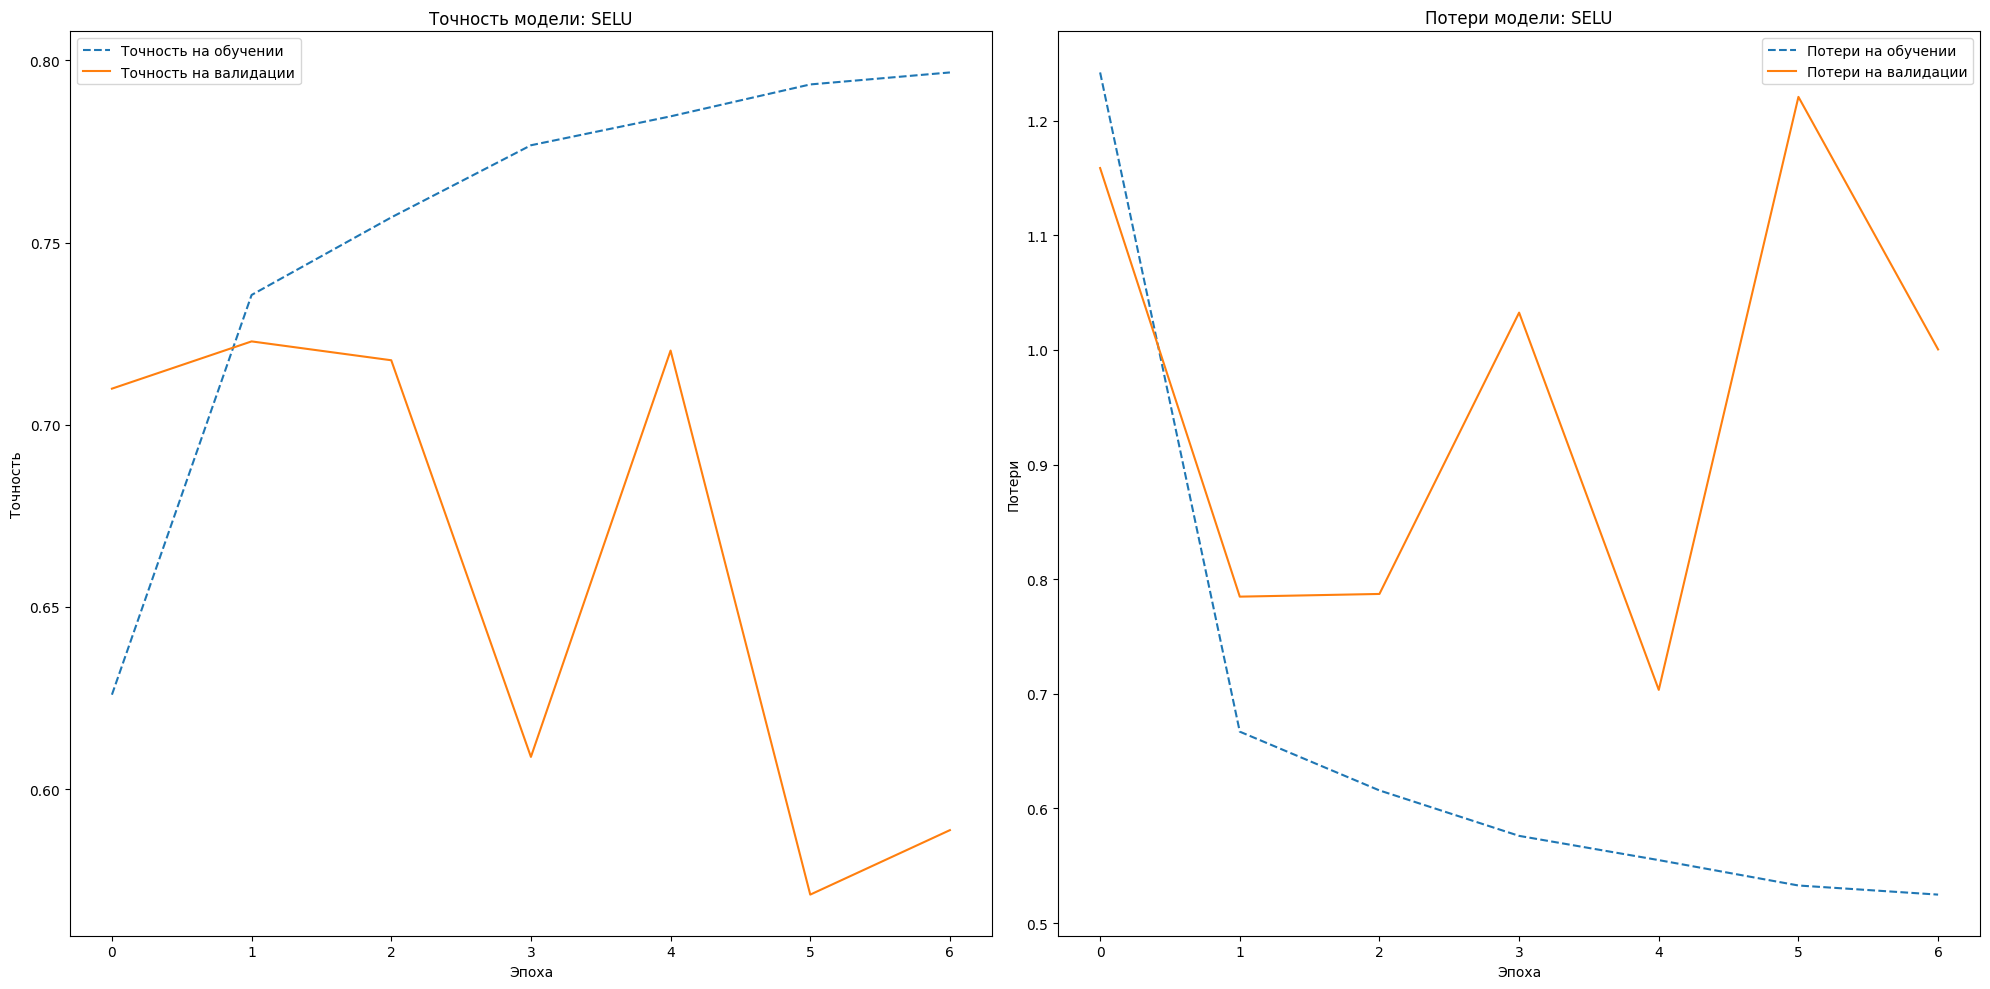

Эксперимент SELU завершен.


Starting experiment: ELU
Parameters: filters=[64, 128, 256, 512, 512], kernel=(3, 3), activation=elu
Epoch 1/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 136s 475ms/step - loss: 1.2850 - sparse_categorical_accuracy: 0.5917 - val_loss: 1.2237 - val_sparse_categorical_accuracy: 0.6991
Epoch 2/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 117s 418ms/step - loss: 0.6635 - sparse_categorical_accuracy: 0.7407 - val_loss: 1.9013 - val_sparse_categorical_accuracy: 0.4584
Epoch 3/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 142s 418ms/step - loss: 0.5922 - sparse_categorical_accuracy: 0.7728 - val_loss: 0.8665 - val_sparse_categorical_accuracy: 0.6830
Epoch 4/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 99s 417ms/step - loss: 0.5679 - sparse_categorical_accuracy: 0.7811 - val_loss: 0.7173 - val_sparse_categorical_accuracy: 0.7128
Epoch 5/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 141s 414ms/step - loss: 0.5336 - sparse_categorical_accuracy: 0.7939 - val_loss: 0.7088 - val_sparse_categorical_accuracy: 0.7149
Epoch 6/7
238/238 ━━━━━━━━

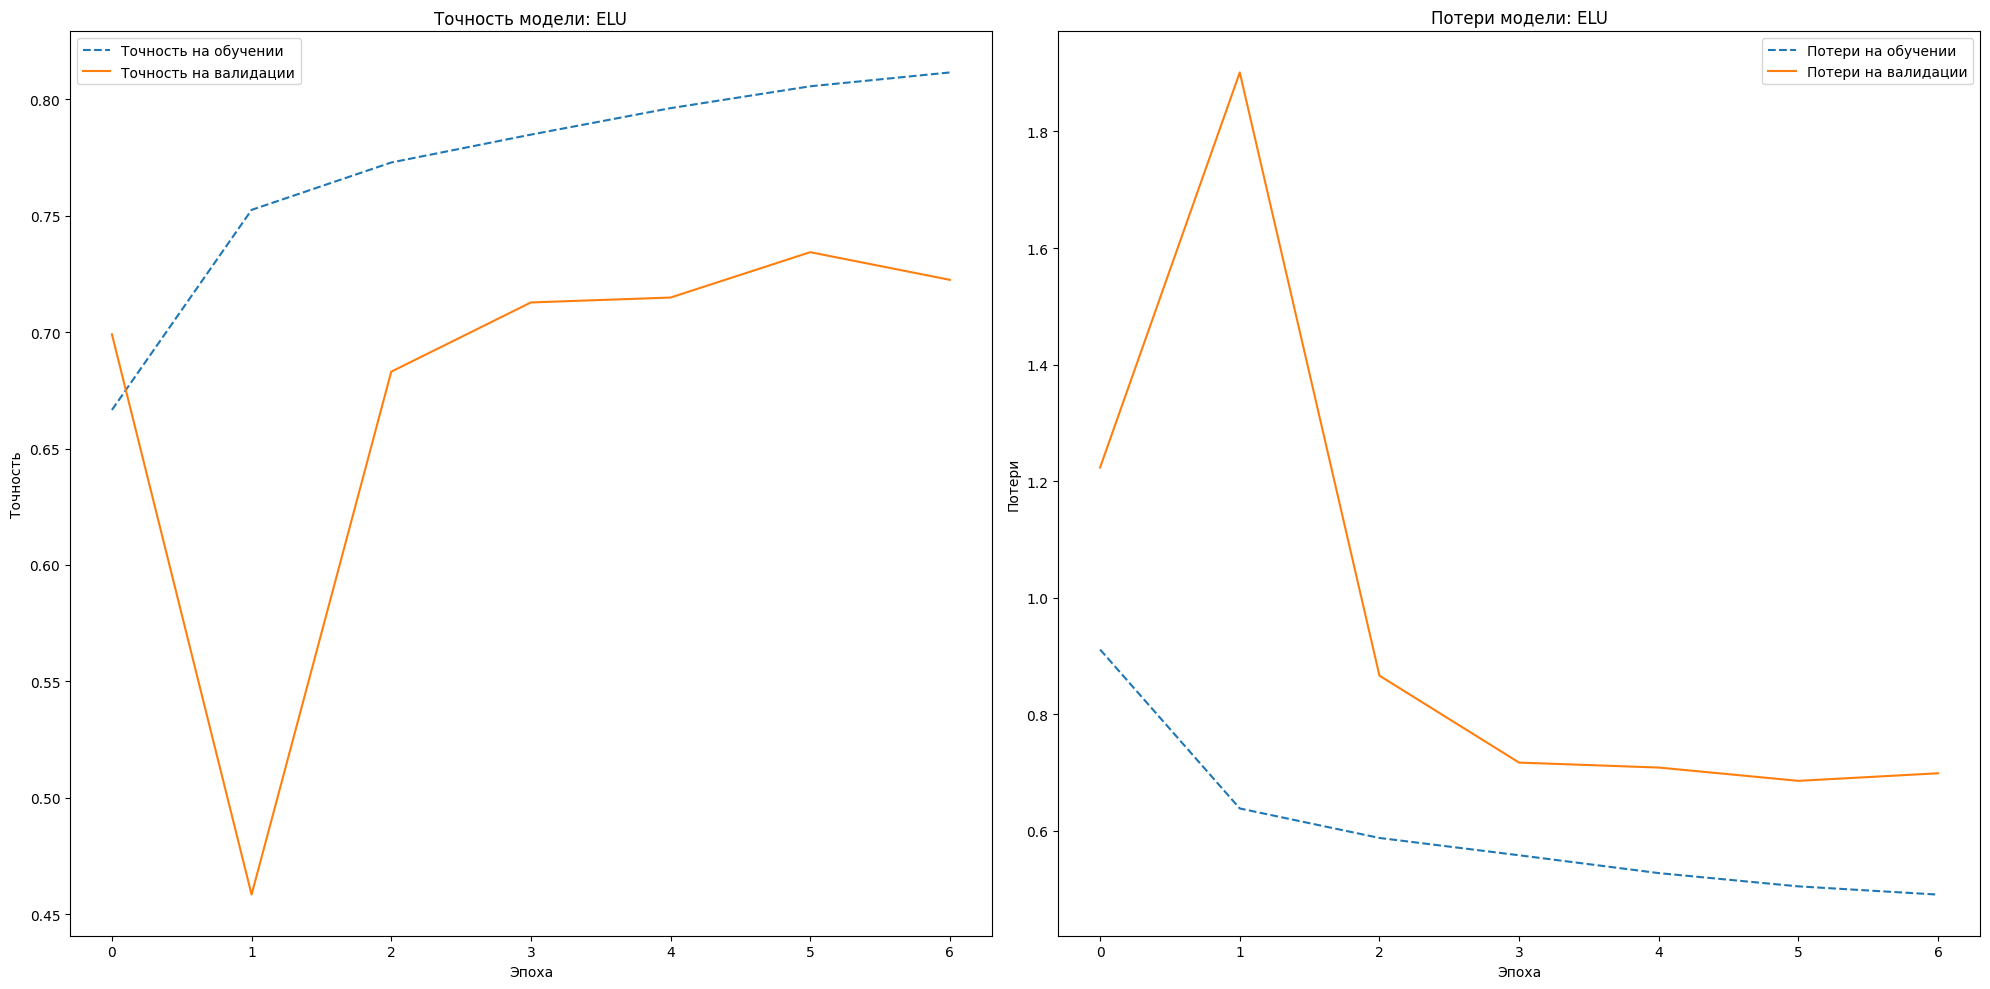

Эксперимент ELU завершен.


Starting experiment: Kernel 5,5 и ELU
Parameters: filters=[64, 128, 256, 512, 512], kernel=(5, 5), activation=elu
Epoch 1/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 326s 1s/step - loss: 1.2348 - sparse_categorical_accuracy: 0.6124 - val_loss: 1.5547 - val_sparse_categorical_accuracy: 0.6565
Epoch 2/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 189s 795ms/step - loss: 0.6242 - sparse_categorical_accuracy: 0.7590 - val_loss: 0.8592 - val_sparse_categorical_accuracy: 0.6452
Epoch 3/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 202s 795ms/step - loss: 0.5878 - sparse_categorical_accuracy: 0.7761 - val_loss: 0.7200 - val_sparse_categorical_accuracy: 0.7202
Epoch 4/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 203s 799ms/step - loss: 0.5832 - sparse_categorical_accuracy: 0.7763 - val_loss: 0.7422 - val_sparse_categorical_accuracy: 0.7363
Epoch 5/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 190s 797ms/step - loss: 0.5605 - sparse_categorical_accuracy: 0.7864 - val_loss: 0.7434 - val_sparse_categorical_accuracy: 0.7433
Epoch 6/7
238/23

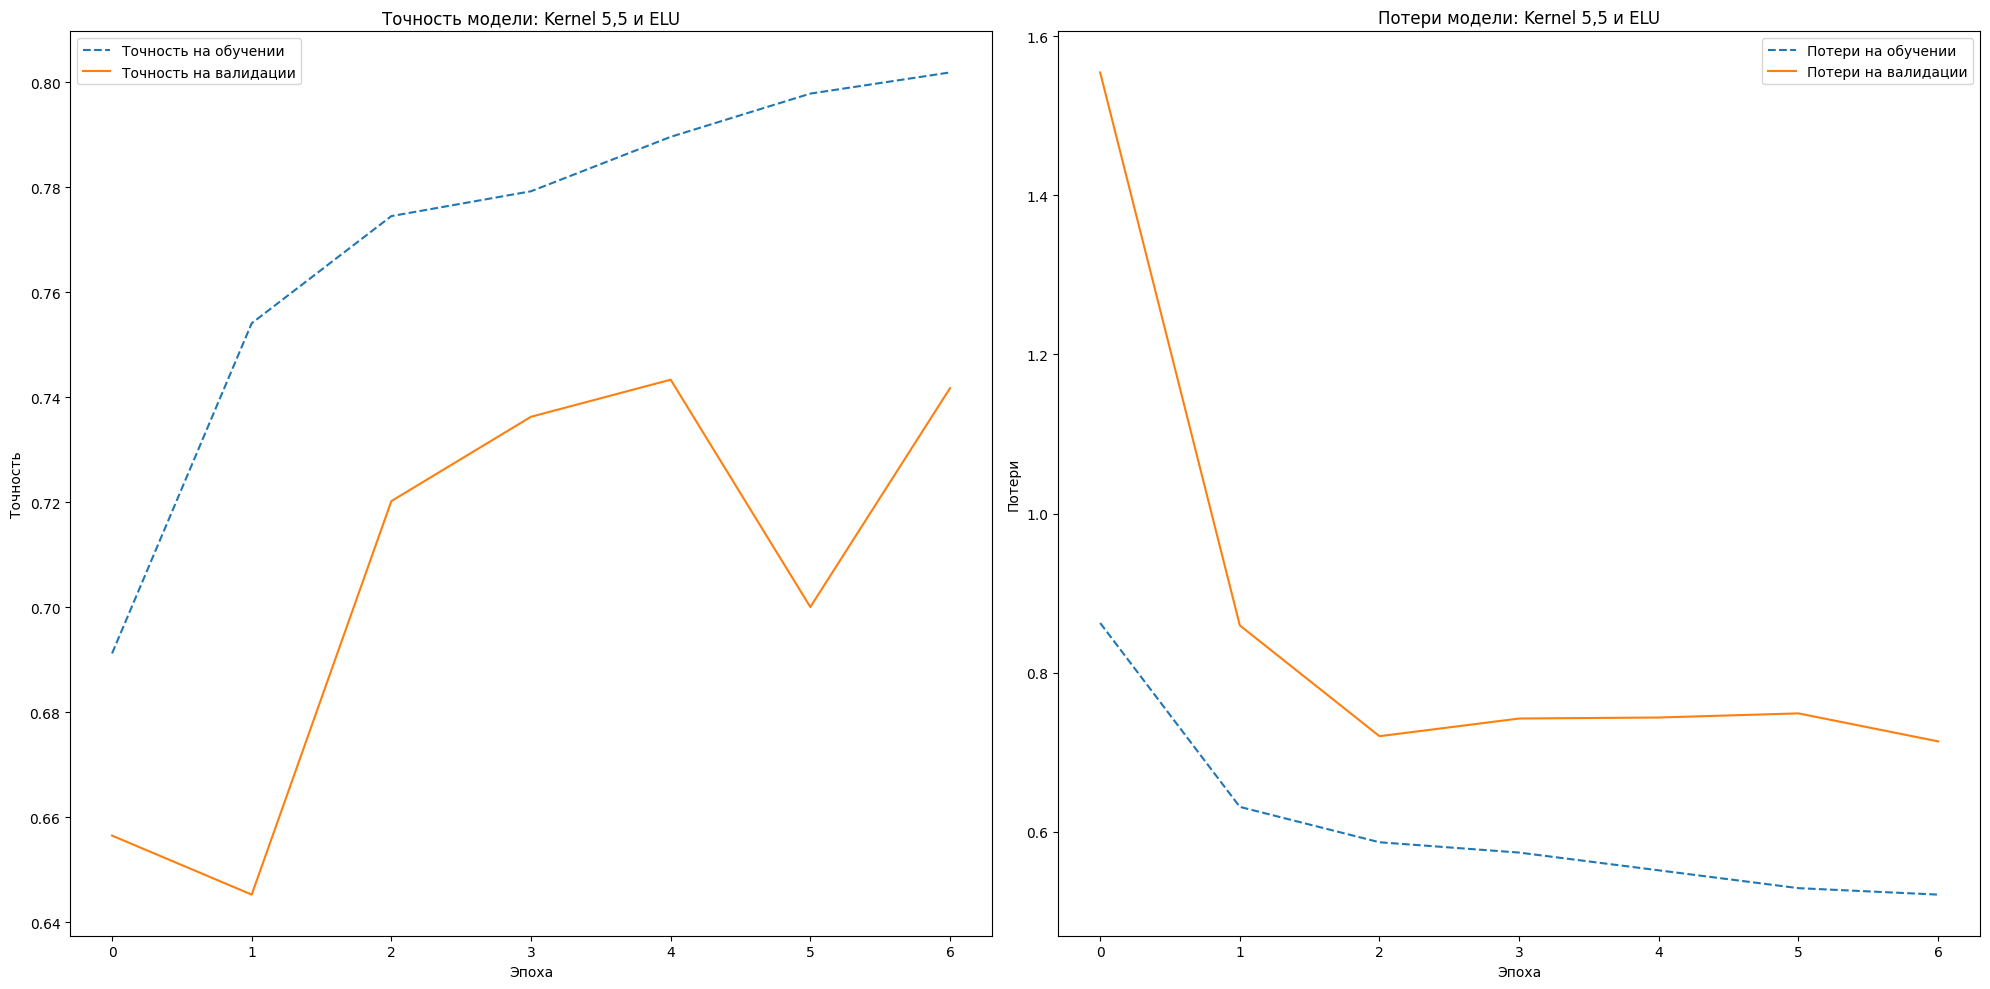

Эксперимент Kernel 5,5 и ELU завершен.


Starting experiment: Filters*2 и SELU
Parameters: filters=[128, 256, 512, 1024, 1024], kernel=(3, 3), activation=selu
Epoch 1/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 523s 2s/step - loss: 1.9592 - sparse_categorical_accuracy: 0.5104 - val_loss: 1.1097 - val_sparse_categorical_accuracy: 0.6997
Epoch 2/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 375s 1s/step - loss: 0.7442 - sparse_categorical_accuracy: 0.6912 - val_loss: 0.9048 - val_sparse_categorical_accuracy: 0.6996
Epoch 3/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 323s 1s/step - loss: 0.6488 - sparse_categorical_accuracy: 0.7407 - val_loss: 0.8018 - val_sparse_categorical_accuracy: 0.6567
Epoch 4/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 381s 1s/step - loss: 0.6289 - sparse_categorical_accuracy: 0.7498 - val_loss: 0.8485 - val_sparse_categorical_accuracy: 0.6880
Epoch 5/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 377s 1s/step - loss: 0.5972 - sparse_categorical_accuracy: 0.7636 - val_loss: 0.8518 - val_sparse_categorical_accuracy: 0.6783
Epoch 6/7
2

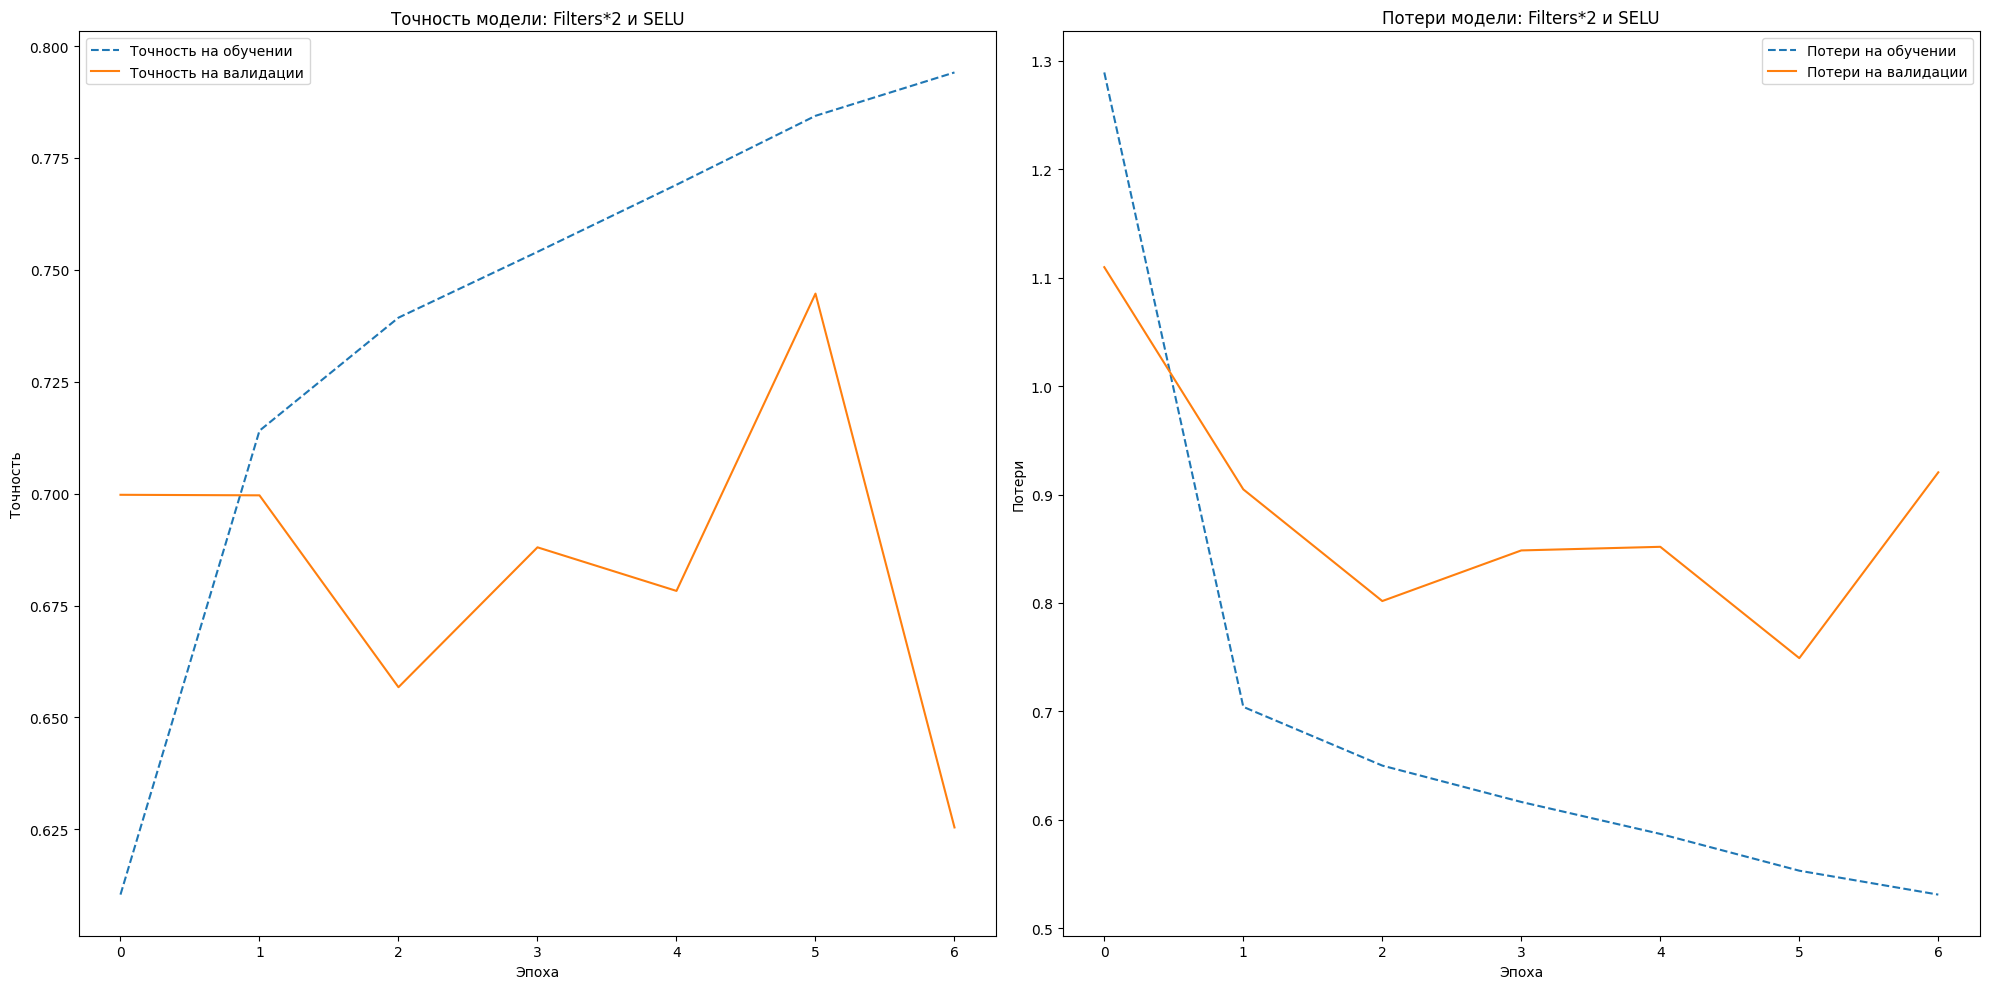

Эксперимент Filters*2 и SELU завершен.


Starting experiment: Kernel_sizes
Parameters: filters=[64, 128, 256, 512, 512], kernel=[(5, 5), (3, 3), (3, 3), (1, 1), (1, 1)], activation=relu
Epoch 1/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 139s 490ms/step - loss: 0.9778 - sparse_categorical_accuracy: 0.6449 - val_loss: 1.0955 - val_sparse_categorical_accuracy: 0.6052
Epoch 2/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 104s 435ms/step - loss: 0.7020 - sparse_categorical_accuracy: 0.7152 - val_loss: 1.5750 - val_sparse_categorical_accuracy: 0.4370
Epoch 3/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 140s 427ms/step - loss: 0.6540 - sparse_categorical_accuracy: 0.7296 - val_loss: 0.8829 - val_sparse_categorical_accuracy: 0.6166
Epoch 4/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 142s 427ms/step - loss: 0.5999 - sparse_categorical_accuracy: 0.7598 - val_loss: 0.8834 - val_sparse_categorical_accuracy: 0.6518
Epoch 5/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 141s 422ms/step - loss: 0.5918 - sparse_categorical_accuracy: 0.7603 - val_loss: 0.9655 - val_spars

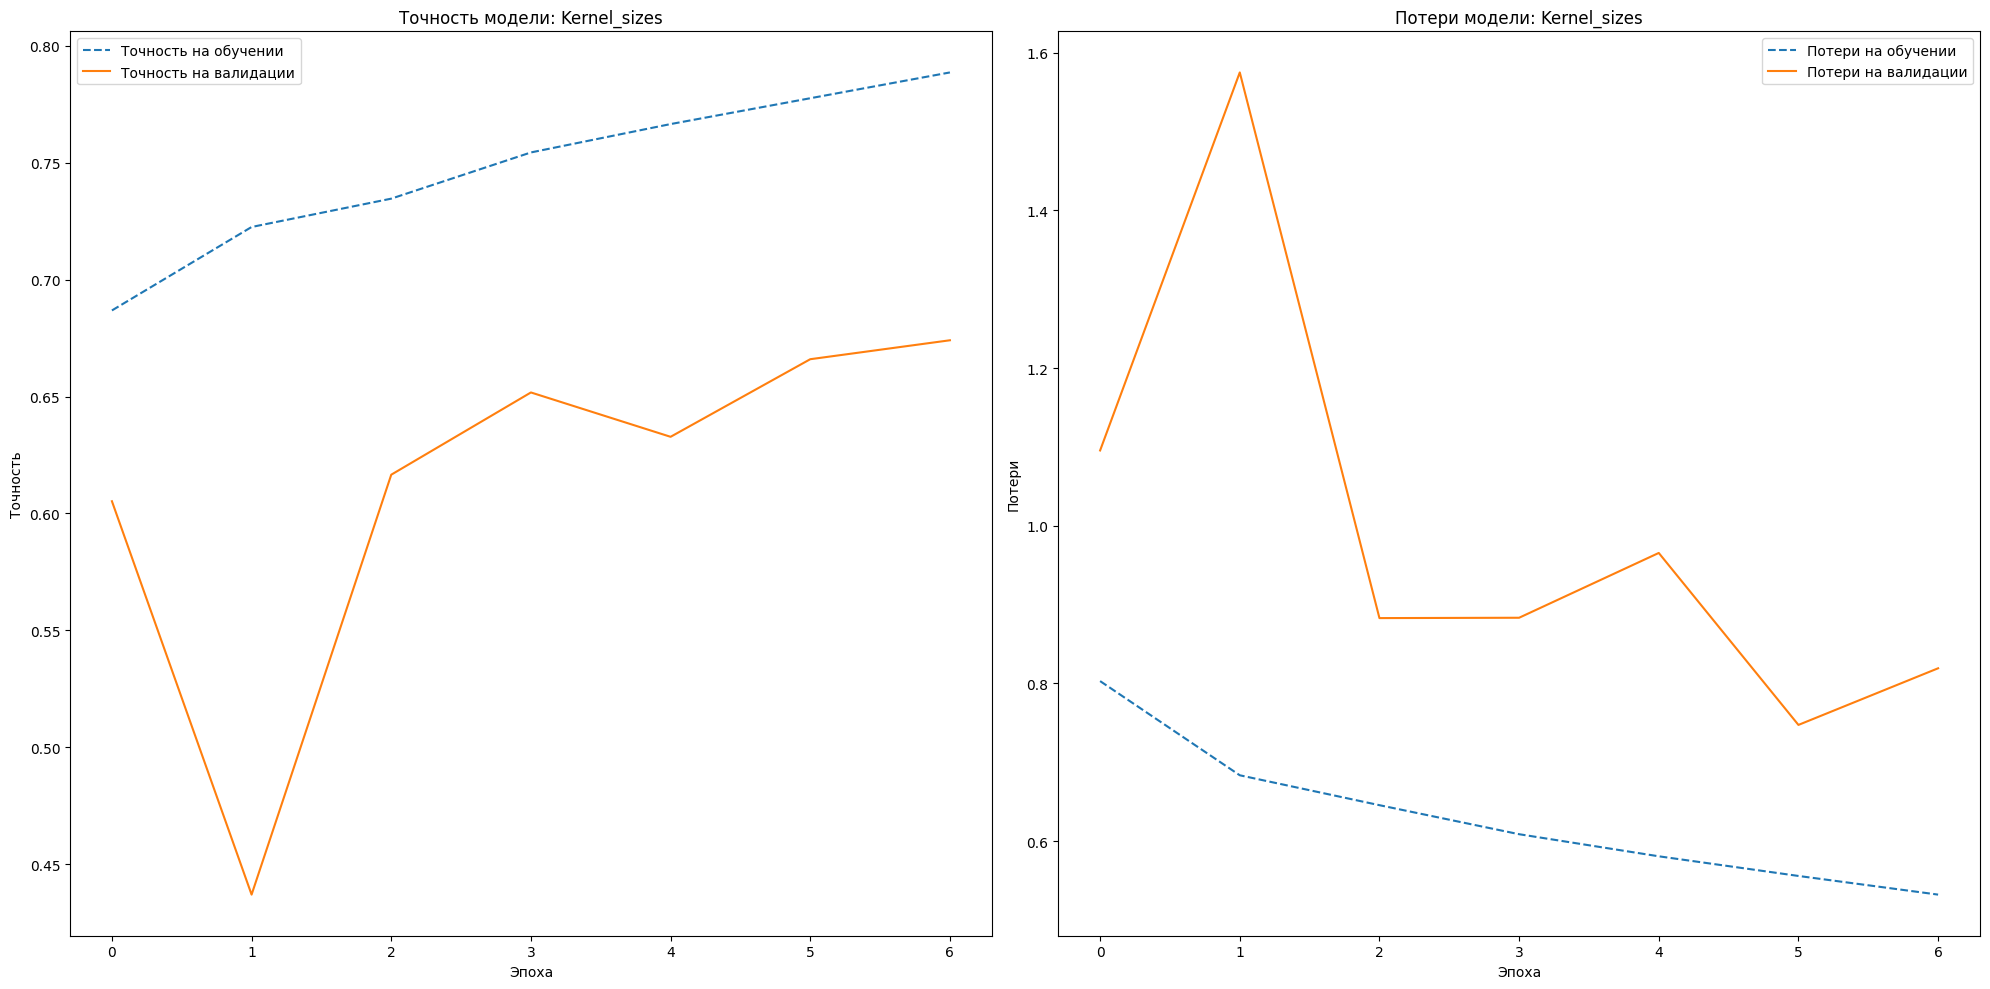

Эксперимент Kernel_sizes завершен.



In [ ]:
skip_list = ["Basic", "Filters*2", "Filters_del_2", "Kernel 5, 5"]

# Цикл обучения
histories = []
for exp in experiments:
    if exp['name'] in skip_list:
        print(f"\nSkipping experiment: {exp['name']}")
        continue
    print(f"\nStarting experiment: {exp['name']}")
    print(f"Parameters: filters={exp['filters']}, kernel={exp['kernel_size']}, activation={exp['activation']}")

    # Создание модели
    model = masked_unet(
        class_count=NUM_CLASSES,
        input_shape=(IMG_WIDTH, IMG_HEIGHT, 3),
        filters_list=exp['filters'],
        kernel_size=exp['kernel_size'],
        activation=exp['activation']
    )

    # Обучение
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=7,
        batch_size=8,
        verbose=1
    )

    # Сохранение истории обучения
    histories.append({
        'name': exp['name'],
        'history': history.history,
        'params': exp
    })

    # Сохранение весов модели
    safe_name = exp['name'].replace(' ', '_').lower()
    weights_filename = f"{safe_name}.weights.h5"
    model.save_weights(weights_filename)
    print(f"Веса сохранены в {weights_filename}")

    # Визуализация для текущей модели
    plt.figure(figsize=(20, 10))

    # График точности
    plt.subplot(1, 2, 1)
    plt.plot(history.history['sparse_categorical_accuracy'], '--', label='Точность на обучении')
    plt.plot(history.history['val_sparse_categorical_accuracy'], '-', label='Точность на валидации')
    plt.title(f'Точность модели: {exp["name"]}')
    plt.ylabel('Точность')
    plt.xlabel('Эпоха')
    plt.legend()

    # График потерь
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], '--', label='Потери на обучении')
    plt.plot(history.history['val_loss'], '-', label='Потери на валидации')
    plt.title(f'Потери модели: {exp["name"]}')
    plt.ylabel('Потери')
    plt.xlabel('Эпоха')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Очистка памяти
    del model
    gc.collect()
    print(f"Эксперимент {exp['name']} завершен.\n")

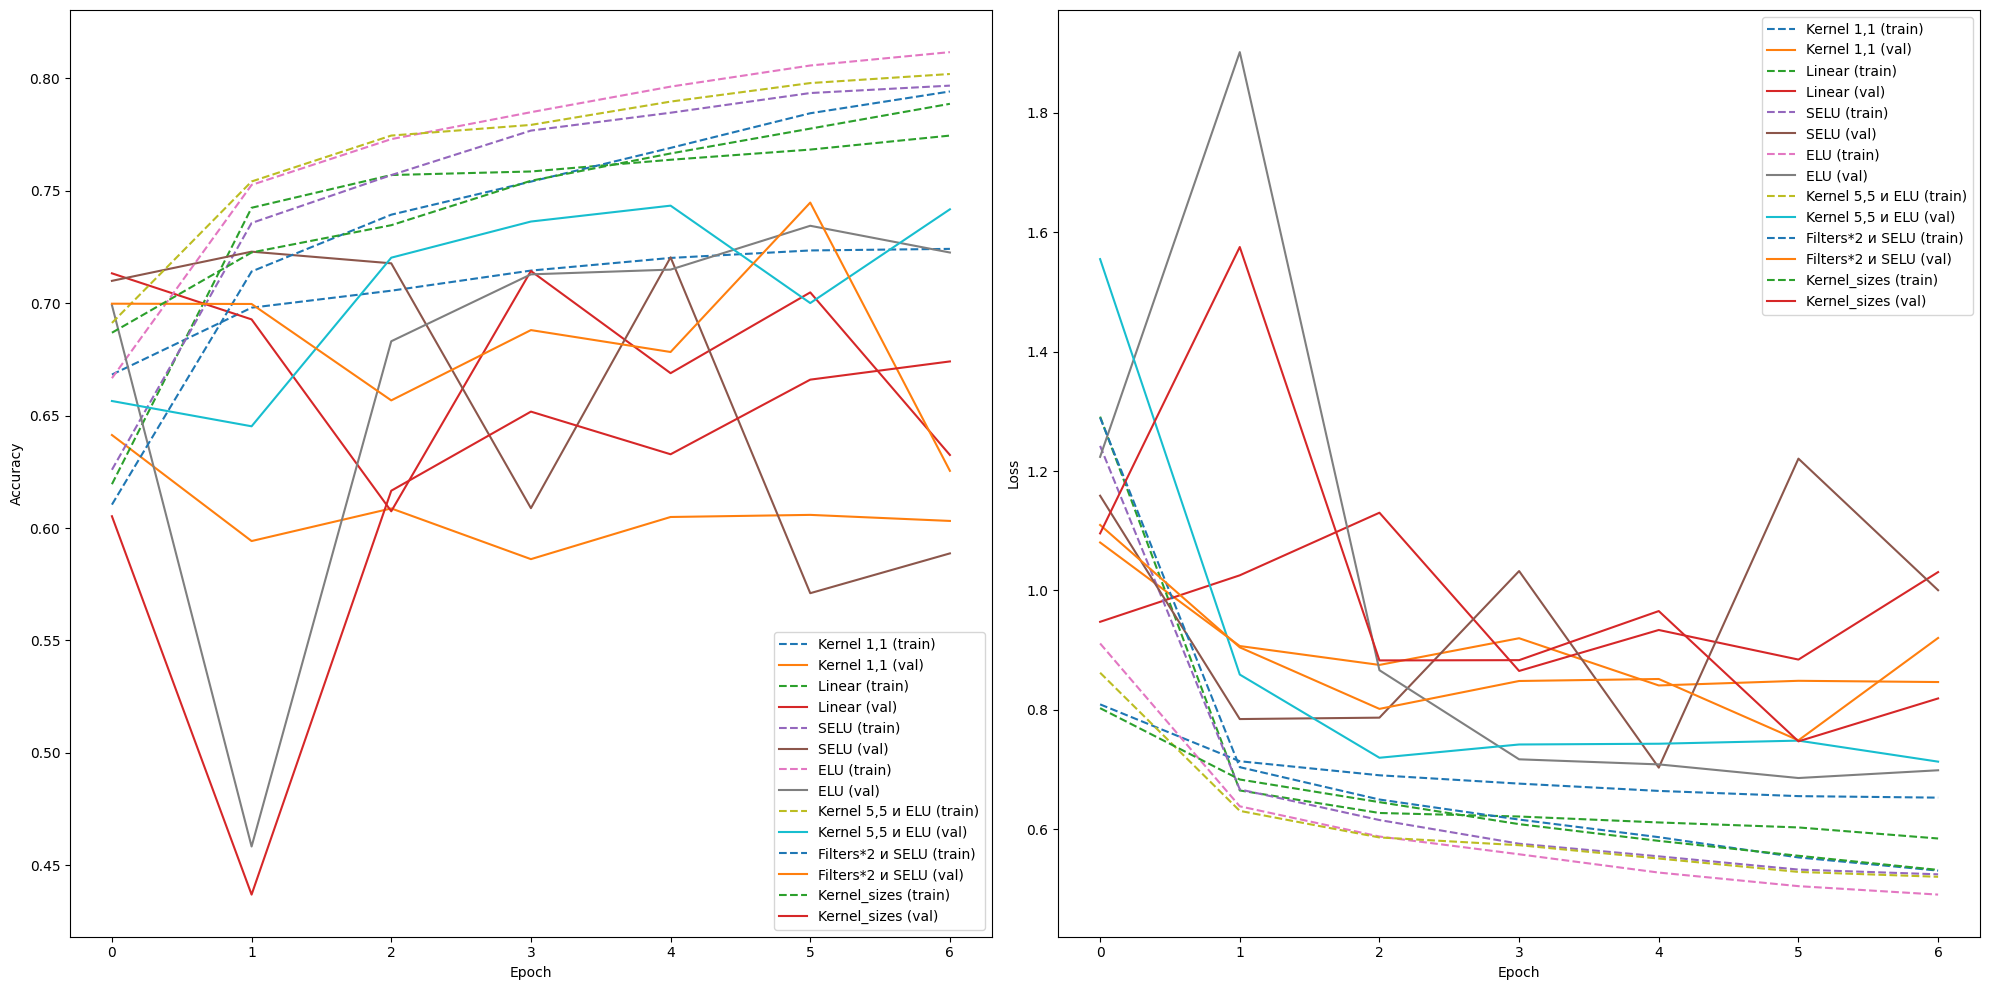

In [ ]:
# Визуализация всех моделей
plt.figure(figsize=(20, 10))

# Точность
plt.subplot(1, 2, 1)
for hist in histories:
    plt.plot(hist['history']['sparse_categorical_accuracy'], '--', label=hist['name'] + ' (train)')
    plt.plot(hist['history']['val_sparse_categorical_accuracy'], '-', label=hist['name'] + ' (val)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Потери
plt.subplot(1, 2, 2)
for hist in histories:
    plt.plot(hist['history']['loss'], '--', label=hist['name'] + ' (train)')
    plt.plot(hist['history']['val_loss'], '-', label=hist['name'] + ' (val)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()